# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, our goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



In [1]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate, StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer, make_column_selector

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC, SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, make_scorer, average_precision_score, precision_recall_curve, roc_curve, f1_score, roc_auc_score, ConfusionMatrixDisplay,make_scorer, RocCurveDisplay, PrecisionRecallDisplay, auc as skl_auc

from sklearn import set_config
set_config(display="diagram")

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import pandas as pd

from autoviz import AutoViz_Class

Imported v0.1.905. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [2]:
# The dataset collected is reported to be collected for 17 direct marketing campaigns that occurred between May 2008 and November 2010,
# corresponding to a total of 41188 contacts. 
# During these phone campaigns, an attractive long-term deposit application, with good interest rates, was offered.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [2]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

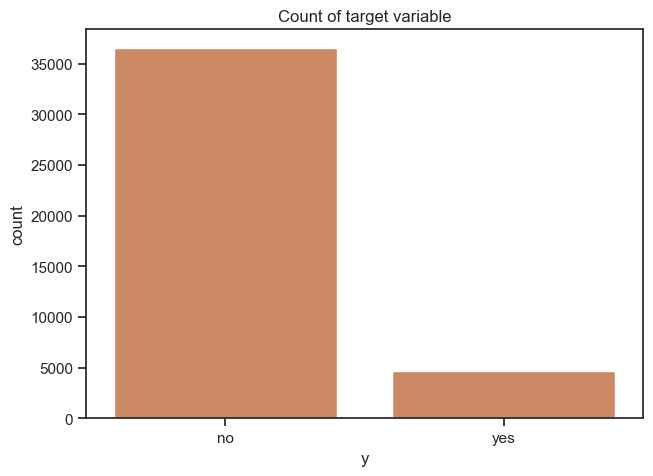

In [6]:
# Count Plot of target variable 'y'
%matplotlib inline
df['y'].value_counts(normalize=True)

sns.countplot(x='y', data=df)
plt.title('Count of target variable')
plt.show()

In [16]:
#########################################################################################################
# PreLiminary EDA: Data Visualization with AutoViz library (credits: https://github.com/AutoViML/AutoViz)
#########################################################################################################
AV = AutoViz_Class()

plots_output = "plots/autoviz_plots_notcleaned_data"
dft = AV.AutoViz(
    "",
    sep=",",
    depVar="y",
    dfte=df,
    header=0,
    verbose=2,
    lowess=True,
    chart_format="svg",
    max_rows_analyzed=150000,
    max_cols_analyzed=30,
    save_plot_dir=plots_output
)

Shape of your Data Set loaded: (41188, 21)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
  Printing up to 30 columns (max) in each category:
    Numeric Columns : ['cons.price.idx', 'cons.conf.idx', 'euribor3m', 'emp.var.rate', 'nr.employed']
    Integer-Categorical Columns: ['age', 'duration', 'campaign', 'pdays', 'previous']
    String-Categorical Columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'day_of_week', 'poutcome']
    Factor-Categorical Columns: []
    String-Boolean Columns: ['contact']
    Numeric-Boolean Columns: []
    Discrete String Columns: []
    NLP text Columns: []
    Date Time Columns: []
    ID Columns: []
    Columns that will not be considered in modeling: []
    20 Predictors cla

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
age,int64,0.000000,0,17.000000,98.000000,Column has 468 outliers greater than upper bound (69.50) or lower than lower bound(9.50). Cap them or remove them.
job,object,0.000000,0,,,1 rare categories: ['unknown']. Group them into a single category or drop the categories.
marital,object,0.000000,0,,,1 rare categories: ['unknown']. Group them into a single category or drop the categories.
education,object,0.000000,0,,,1 rare categories: ['illiterate']. Group them into a single category or drop the categories.
default,object,0.000000,0,,,1 rare categories: ['yes']. Group them into a single category or drop the categories.
housing,object,0.000000,0,,,No issue
loan,object,0.000000,0,,,No issue
contact,object,0.000000,0,,,No issue
month,object,0.000000,0,,,1 rare categories: ['dec']. Group them into a single category or drop the categories.
day_of_week,object,0.000000,0,,,No issue


Total Number of Scatter Plots = 15
All Plots are saved in plots/autoviz_plots_notcleaned_data/y
Time to run AutoViz = 11 seconds 


In [7]:
###############################################################################
# Exploratory Data Analysis
###############################################################################

###############################################################################
# 1. Identify and handle Duplicate Rows (exclude first occurence)
###############################################################################
def handle_duplicates(df):
    """
    Identifies, displays, counts, and drops duplicate rows in a DataFrame.

    Parameters:
    - df: pandas DataFrame

    Returns:
    - DataFrame with duplicate rows removed
    """
    # Identify duplicate rows
    duplicate_rows = df.duplicated()
    
    # Display duplicate rows
    duplicates = df[duplicate_rows]
    print("\nActual Duplicate Rows:")
    print(duplicates)
    
    # Count duplicate rows
    duplicate_count = duplicate_rows.sum()
    print("\nNumber of Duplicate Rows:", duplicate_count)
    
    # Drop duplicate rows
    df_cleaned = df.drop_duplicates()
    print("\nAfter dropping duplicate rows, the count of duplicate rows now: ", df_cleaned.duplicated().sum())
    
    return df_cleaned

df_cleaned = handle_duplicates(df)



###############################################################################
# 2. Cap outliers for age, duration, campaign, pdays, previous, cons.conf.idx
###############################################################################
def cap_outliers(df_cleaned, column, lower_bound, upper_bound):
    """
    Cap outliers in a specified column of input DataFrame to the given bounds.

    Parameters:
    - df: pandas DataFrame
    - column: str, name of the column to process
    - lower_bound: float, lower bound for capping
    - upper_bound: float, upper bound for capping

    Returns:
    - DataFrame with outliers capped
    """
    print(f"\nColumn {column} has outliers greater than upper bound ({upper_bound}) or lower than lower bound ({lower_bound}). Capping them now.")
    df_cleaned[column] = df_cleaned[column].clip(lower=lower_bound, upper=upper_bound)
    return df_cleaned

# Define bounds for each column age, duration, campaign, pdays, previous, cons.conf.idx
age_bounds = (9.50, 69.50)
duration_bounds = (-223.50, 644.50)
campaign_bounds = (-2.00, 6.00)
pdays_bounds = (999.00, 999.00)
previous_bounds = (0.00, 0.00)
cons_conf_idx_bounds = (-52.15, -26.95)

# Cap outliers 
df_cleaned = cap_outliers(df_cleaned, 'age', *age_bounds)
df_cleaned = cap_outliers(df_cleaned, 'duration', *duration_bounds)
df_cleaned = cap_outliers(df_cleaned, 'campaign', *campaign_bounds)
df_cleaned = cap_outliers(df_cleaned, 'pdays', *pdays_bounds)
df_cleaned = cap_outliers(df_cleaned, 'previous', *previous_bounds)
df_cleaned = cap_outliers(df_cleaned, 'cons.conf.idx', *cons_conf_idx_bounds)

###################################################################################
# 3. emp.var.rate - Column has a high correlation with ['euribor3m']
# nr.employed - Column has a high correlation with ['euribor3m', 'emp.var.rate']
###################################################################################
df_cleaned = df_cleaned.drop(columns=['nr.employed', 'emp.var.rate'])



###################################################################################
# 4. Filter out rows for columns meeting a filter criteria
###################################################################################
def filter_and_print(df, columns_to_print, filters):
    """
    Print value counts for specific columns and filter out rows based on given conditions.

    Parameters:
    - df: pandas DataFrame
    - columns_to_print: list of column names to print value counts for
    - filters: dictionary where keys are column names and values are the values to filter out
    """
    # Print value counts for specified columns
    print("\nValue Counts for specific columns:")
    for column in columns_to_print:
        print(f"\n{column}:")
        print(df[column].value_counts())

    # Apply filters
    for column, value_to_filter in filters.items():
        df = df[df[column] != value_to_filter]
    
    return df

# Columns to print value counts for
columns = ['job', 'marital', 'education', 'default', 'month']

# Filters to apply
filters = {
    'job': 'unknown',
    'marital': 'unknown',
    'education': 'illiterate',
    'default': 'yes',
    'month': 'dec'
}

# Apply filter
df_cleaned = filter_and_print(df_cleaned, columns, filters)
print("\n\nSpot check for one of the filtered columns: " , df_cleaned['education'].value_counts())




######################################################################################
# 5. Again, identify and handle any Duplicate Rows (if any)
######################################################################################
df_cleaned = handle_duplicates(df_cleaned)
print("\nCount of duplicate rows now: ", df_cleaned.duplicated().sum())


######################################################################################
# 6. Check for any missing values 
######################################################################################
missing_values_per_column = df_cleaned.isna().sum()
print("\nMissing values per column: ", missing_values_per_column)

missing_values_per_row = df_cleaned.isna().sum(axis=1)
print("\nMissing values per row: ", missing_values_per_row)

total_missing = df_cleaned.isna().sum().sum()
print("\nTotal missing values: ", total_missing)

columns_with_missing = df_cleaned.columns[df_cleaned.isna().any()].tolist()
rows_with_missing = df_cleaned.index[df_cleaned.isna().any(axis=1)].tolist()
print("\nColumns with missing values:", columns_with_missing)
print("\nRows with missing values:", rows_with_missing)



Actual Duplicate Rows:
       age     job       marital       education       default  housing loan  \
1266   39   blue-collar   married             basic.6y       no     no   no    
12261  36       retired   married              unknown       no     no   no    
14234  27    technician    single  professional.course       no     no   no    
16956  47    technician  divorced          high.school       no    yes   no    
18465  32    technician    single  professional.course       no    yes   no    
20216  55      services   married          high.school  unknown     no   no    
20534  41    technician   married  professional.course       no    yes   no    
25217  39        admin.   married    university.degree       no     no   no    
28477  24      services    single          high.school       no    yes   no    
32516  35        admin.   married    university.degree       no    yes   no    
36951  45        admin.   married    university.degree       no     no   no    
38281  71       

In [18]:
#########################################################################################################
# Visualizing cleaned data-set: with AutoViz library (credits: https://github.com/AutoViML/AutoViz)
#########################################################################################################
plots_cleaned_output = "plots/autoviz_plots_cleaned_data"
dft_new = AV.AutoViz(
    "",
    sep=",",
    depVar="y",
    dfte=df_cleaned,
    header=0,
    verbose=2,
    lowess=True,
    chart_format="svg",
    max_rows_analyzed=150000,
    max_cols_analyzed=30,
    save_plot_dir=plots_cleaned_output
)



Shape of your Data Set loaded: (40565, 19)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
  Printing up to 30 columns (max) in each category:
    Numeric Columns : ['age', 'duration', 'cons.price.idx', 'cons.conf.idx', 'euribor3m']
    Integer-Categorical Columns: ['campaign']
    String-Categorical Columns: ['job', 'marital', 'education', 'housing', 'loan', 'month', 'day_of_week', 'poutcome']
    Factor-Categorical Columns: []
    String-Boolean Columns: ['default', 'contact']
    Numeric-Boolean Columns: []
    Discrete String Columns: []
    NLP text Columns: []
    Date Time Columns: []
    ID Columns: []
    Columns that will not be considered in modeling: ['pdays', 'previous']
    18 Predictors classified...
        2 variable(s) 

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
age,float64,0.000000,NA,17.000000,69.500000,No issue
job,object,0.000000,0,,,No issue
marital,object,0.000000,0,,,No issue
education,object,0.000000,0,,,No issue
default,object,0.000000,0,,,No issue
housing,object,0.000000,0,,,No issue
loan,object,0.000000,0,,,No issue
contact,object,0.000000,0,,,No issue
month,object,0.000000,0,,,No issue
day_of_week,object,0.000000,0,,,No issue


Total Number of Scatter Plots = 15
All Plots are saved in plots/autoviz_plots_cleaned_data/y
Time to run AutoViz = 10 seconds 


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```




After cleaning, listing all features: Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'y'],
      dtype='object')
Does 'y' contain NaNs? False
Count of missing values in 'y': 0
Does 'X' contain NaNs? False
Feature: duration, Importance: 0.039156908665105336
Feature: euribor3m, Importance: 0.025139898927646953
Feature: cons.conf.idx, Importance: 0.009890299519290002
Feature: cons.price.idx, Importance: 0.006665844940219367
Feature: age, Importance: 0.005137433748305165
Feature: campaign, Importance: 0.0036164180944163295
Feature: poutcome, Importance: 0.0025194132873166296
Feature: month, Importance: 0.0010822137310489087
Feature: loan, Importance: 0.00045852335757423646
Feature: day_of_week, Importance: 0.0004486626402070315
Feature: default, Importance: 0.0002465179341796686
Feature: contact, Import

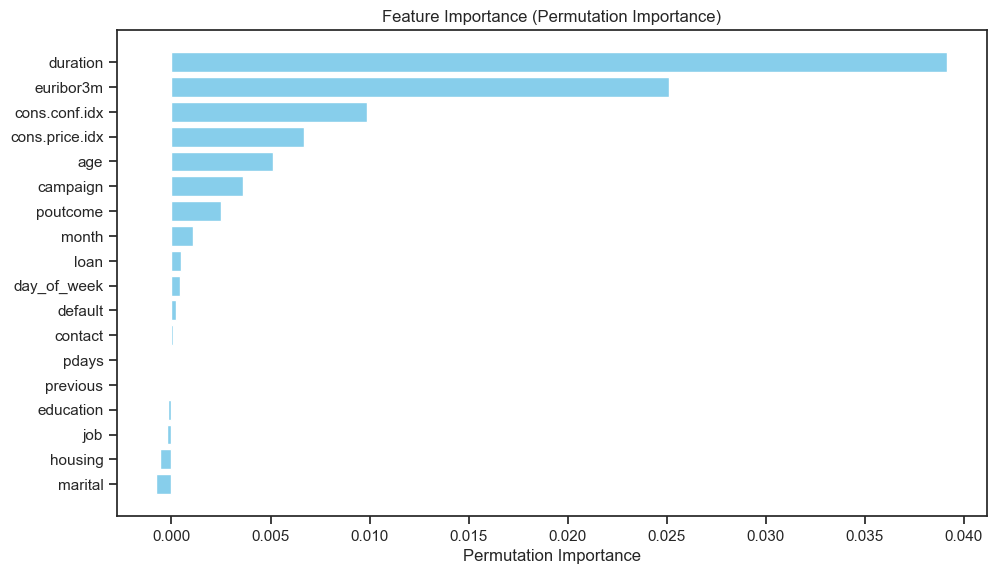


After dropping ALL zero (pdays, previous), 2 low importance features (contact, default) and 1 negative importance features (marital, housing), listing features:  Index(['age', 'job', 'education', 'loan', 'month', 'day_of_week', 'duration',
       'campaign', 'poutcome', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'y'],
      dtype='object')


In [8]:
################################################################################################
# Outlining EDA completed thus far as part of reading the data, with some conclusions
################################################################################################

# 1. No missing values in rows or columns 

# 2. Found duplicate rows that were cleaned up

# 3. There were several missing values in some categorical features, coded with "unknown" label. 
# Filtered out rows where number of those samples where minimal

# 4. Dropped 2 features that were correlated to euribor3m: [ 'nr.employed', 'emp.var.rate' ]

# 5. Recleaned duplicates after removing outliers as well

# 6. EDA Observations - No linear relationships with observed
# Other observations with specific features - will be captured in Detailed Report

################################################################################################
# Understanding Features 
################################################################################################

# Identify predictors that are numerics, categorical, binary categorical - excluded target variable 'y' in this
all_numeric_features = ['age', 'duration', 'campaign', 'pdays', 'previous', 'cons.price.idx', 'cons.conf.idx', 'euribor3m']
all_categorical_features = ['job', 'marital', 'education', 'contact', 'month', 'day_of_week', 'poutcome', 'default', 'housing', 'loan'] 
binary_categorical_features = ['default', 'housing', 'loan'] 


# Apply mapping to target 'y' feature
mapping = {'yes': 1, 'no': 0}
df_cleaned['y'] = df_cleaned['y'].map(mapping)
print("\nAfter cleaning, listing all features:", df_cleaned.columns)

# X for all predictors and y for target feature
X = df_cleaned.drop('y', axis=1)
y = df_cleaned['y']

# Re-check for missing values prior to training a basic model 
has_nan = df_cleaned['y'].isna().any()
print(f"Does 'y' contain NaNs? {has_nan}")
missing_count = df_cleaned['y'].isna().sum()
print("Count of missing values in 'y':", missing_count)
has_nan_x = X.isna().any().any()
print(f"Does 'X' contain NaNs? {has_nan_x}")

################################################################################################
# Feature selection based on their feature importance
################################################################################################

# Initial Model Selection: Considered an SVM with an RBF kernel to use as an estimator for permuation importance. 
# However, due to the high computational cost and long training time, feature selection was needed to reduce model's complexity 
# prior to even using this as an initial estimator.
# Model Adjustment: Given the computational constraints, K-Nearest Neighbors (KNN) was selected as an alternative for this early iteration. 
# KNN, being a distance-based model, was chosen due to its simplicity and efficiency in handling the data at this early stage.

# Feature pre-processing
preprocessor = make_column_transformer(
                    (OneHotEncoder(handle_unknown='ignore', drop = 'if_binary', categories = 'auto'), all_categorical_features),
                    (StandardScaler(), all_numeric_features),
                    remainder='passthrough')
init_pipe = Pipeline([('transform', preprocessor), ('model', KNeighborsClassifier(metric='minkowski'))])
init_pipe.fit(X, y)

result = permutation_importance(init_pipe, X, y, n_repeats=10, random_state=42)

# Rank features by importance
sorted_indices = result.importances_mean.argsort()[::-1]
for i in sorted_indices:
    print(f"Feature: {X.columns[i]}, Importance: {result.importances_mean[i]}")
    
# Get feature names and corresponding importances
feature_names = X.columns[sorted_indices]
importances = result.importances_mean[sorted_indices]

# Plot bar graph
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Permutation Importance')
plt.title('Feature Importance (Permutation Importance)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()
    
################################################################################################
# Conclusion: Considering features that can be dropped from their feature importance:
# Zero-Importance features: Historical information from previous campaigns - pdays, previous
# Low- Importance features: month, loan, day_of_week, default, contract
# Negative-Importance features: education, job, housing, marital

# Decided to drop zero and low-importance feature(s): pdays, previous, contract, marital as
# these were observed to be safe from their KDE plots in addition to their feature importances.
################################################################################################

# Dropping columns based on their importance. Started with dropping pdays, previous, contact and marital. 
# Then, with LGR early iterations confirmed housing and default could also be dropped.
columns_to_drop = ['pdays', 'previous', 'contact', 'marital', 'housing', 'default'] 

# df_optimal made by dropping specified columns from df_cleaned
df_optimal = df_cleaned.copy()
df_optimal = df_optimal.drop(columns=columns_to_drop)

print("\nAfter dropping ALL zero (pdays, previous), 2 low importance features (contact, default) and 1 negative importance features (marital, housing), listing features: ", df_optimal.columns)


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [9]:
df_optimal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40565 entries, 0 to 41187
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             40565 non-null  float64
 1   job             40565 non-null  object 
 2   education       40565 non-null  object 
 3   loan            40565 non-null  object 
 4   month           40565 non-null  object 
 5   day_of_week     40565 non-null  object 
 6   duration        40565 non-null  float64
 7   campaign        40565 non-null  int64  
 8   poutcome        40565 non-null  object 
 9   cons.price.idx  40565 non-null  float64
 10  cons.conf.idx   40565 non-null  float64
 11  euribor3m       40565 non-null  float64
 12  y               40565 non-null  int64  
dtypes: float64(5), int64(2), object(6)
memory usage: 4.3+ MB


In [35]:
#########################################################################################################
# Understanding the task
#########################################################################################################

# Task Goal:
# The primary goal is to develop a predictive model that determines whether a client will successfully subscribe to a 
# term deposit in the current campaign. The model should focus on:

# Predictive Accuracy: Correctly identifying clients who are likely to subscribe.
# Efficiency: Reducing the number of unnecessary contacts during the campaign, thereby optimizing resources and improving overall campaign effectiveness.

# Objective:
# To build a model that not only accurately predicts client subscriptions but also minimizes the number of contacts made during the campaign, ensuring a balance between 
# high prediction accuracy and operational efficiency.


# Performance Metrics:
# Given the task's objectives of predicting whether a client will subscribe to a term deposit 
# while minimizing unnecessary contacts, the most appropriate evaluation metrics for a classification model will be:

# F1-score: As the harmonic mean of precision and recall, it balances the need to minimize false positives (unnecessary contacts) 
# with the need to avoid missing true positives (actual client subscribers). This is especially useful since there is an imbalance between the classes  where we have more "no" 
# than "yes" responses in the bank-additonal-full dataset. No (88.7%) = client did not subscribe to a term deposit, Yes (11.2%) = client subscribed to a term deposit.

# Area Under the Precision-Recall Curve (PR AUC): The PR AUC as a single metric captures both precision and recall across different threshold settings. 
# This is particularly useful when the positive class (subscription) is rare, as it emphasizes the model’s ability to identify true positives without being overly optimistic.


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

With SMOTE on whole data, count of target : Counter({0: 36071, 1: 36071})
With SMOTE on whole data, normalized value count of target  y
0    0.5
1    0.5
Name: proportion, dtype: float64


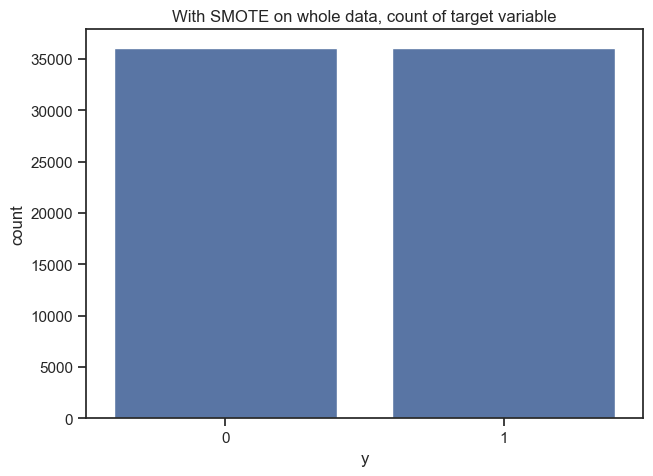

Without SMOTE, count of target : Counter({0: 36071, 1: 4494})
Without SMOTE, normalized value count of target  y
0    0.889215
1    0.110785
Name: proportion, dtype: float64


In [10]:
######################################################################################
# This does not include dropped features:  'nr.employed', 'emp.var.rate' from data 
# cleaning that shows these are correlated to 'euribor3m'
# This also does not include dropped features:  'pdays' 'previous' 'marital' 'contact' 
# from permutation importance
######################################################################################
num_features = ['age', 'duration', 'campaign', 'cons.price.idx', 'cons.conf.idx', 'euribor3m'] # Numeric features
cat_features = ['education', 'job', 'month', 'day_of_week', 'poutcome']                        # Remaining Categorical features without Binary
bin_features = ['loan']                                                                        # Only remaining Binary features                     


#######################################################################################
# OneHotEncoder for bin_features and cat_features
#######################################################################################
encoder = OneHotEncoder(handle_unknown='ignore', drop='if_binary', categories='auto', sparse=False)

# Combine categorical features and binary features
all_features = cat_features + bin_features

# Fit and transform the features
encoded_features = encoder.fit_transform(df_optimal[all_features])

# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(all_features))

# Check for NaNs in the encoded DataFrame
# print("Check for NaNs in encoded dataframe:", encoded_df.isna().sum())
# print("Encoded feature columns:", encoded_df.columns)

# Combine the original DataFrame with the encoded features but reset index before concatenating
df_optimal_dropped = df_optimal.drop(columns=all_features).reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)
df_encoded = pd.concat([df_optimal_dropped, encoded_df], axis=1)

# Check for NaNs in the combined DataFrame
# print("Check for NaNs in combined dataframe:", df_encoded.isna().sum())

# Check for NaNs in the original DataFrame
# print("Check for NaNs (after):", df_encoded.isna().sum())

###################################################################################
# Apply SMOTE to whole since dataset is unbalanced
###################################################################################    
# Separate features and target once again
X_cat = df_encoded.drop(columns=['y'], axis = 1)
y_cat = df_encoded['y']

# Identify all categorical feature columns in the transformed DataFrame
categorical_feature_names = [col for col in encoder.get_feature_names_out(cat_features + bin_features) if any(feat in col for feat in cat_features)]

# Get their indices
categorical_features_indices = [X_cat.columns.get_loc(col) for col in categorical_feature_names]
smote = SMOTENC(categorical_features=categorical_features_indices, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_cat, y_cat)

# Print class distribution after SMOTE
print(f'With SMOTE on whole data, count of target : {Counter(y_resampled)}')
print(f'With SMOTE on whole data, normalized value count of target  {y_resampled.value_counts(normalize=True)}')

# Combine resampled features and target into a DataFrame
df_optimal_resampled = X_resampled
df_optimal_resampled['y'] = y_resampled

# Display the count plot 
%matplotlib inline
sns.countplot(x='y', data=df_optimal_resampled)
plt.title('With SMOTE on whole data, count of target variable')
plt.show()

################################################################################################
# df_optimal_resampled is now a resampled dataframe with SMOTENC. Separate features and target.
################################################################################################
X = df_optimal_resampled.drop('y', axis=1)
y = df_optimal_resampled['y']

################################################################################################
# df_encoded is a encoded dataframe but is NOT resampled with SMOTE
# This is to be used for comparing model scores.
################################################################################################
X1 = df_encoded.drop('y', axis=1)
y1 = df_encoded['y']
print(f'Without SMOTE, count of target : {Counter(y1)}')
print(f'Without SMOTE, normalized value count of target  {y1.value_counts(normalize=True)}')

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.


With SMOTE resampling on all data
X_train shape: (50499, 44)
X_test shape: (21643, 44)
y_train shape: (50499,)
y_test shape: (21643,)

With SMOTE resampling on all data, value_counts in y_train and y_test
y
1    0.50001
0    0.49999
Name: proportion, dtype: float64
y
0    0.500023
1    0.499977
Name: proportion, dtype: float64

Without any SMOTE resampling, value_counts in y1_train and y1_test
y
0    0.889206
1    0.110794
Name: proportion, dtype: float64
y
0    0.889236
1    0.110764
Name: proportion, dtype: float64

With SMOTE resampling on training data, value_counts in y1_train and y1_test
y
0    0.667694
1    0.332306
Name: proportion, dtype: float64
y
0    0.889236
1    0.110764
Name: proportion, dtype: float64


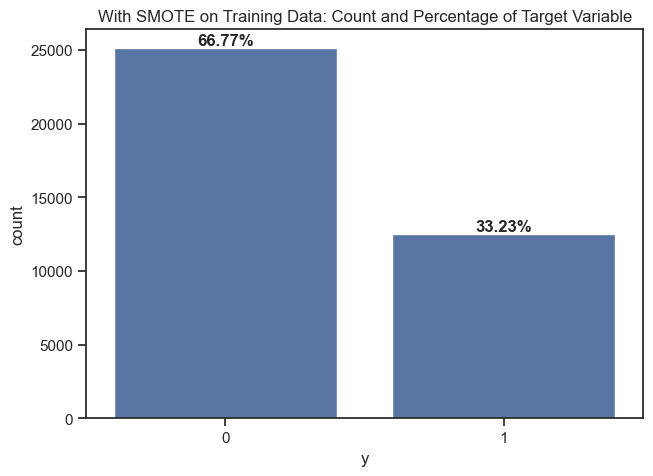

In [11]:
#####################################################################################
# Make test/train dataset with SMOTE resampling on whole data-set
#####################################################################################
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 442, test_size = 0.3, stratify = df_optimal_resampled['y'])

print("\nWith SMOTE resampling on all data")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Value counts of 'y' in y_train and y_test
print("\nWith SMOTE resampling on all data, value_counts in y_train and y_test")
print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize=True))


#####################################################################################
# Make test/train dataset without SMOTE. Then, resample only training data. 
#####################################################################################
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state = 442, test_size = 0.3, stratify = df_optimal['y'])

# Value counts of 'y' in y1_train and y1_test
print("\nWithout any SMOTE resampling, value_counts in y1_train and y1_test")
print(y1_train.value_counts(normalize = True))
print(y1_test.value_counts(normalize=True))

# Now, resample training data with SMOTETomek, set sampling_strategy to 0.5 
# Applies both oversampling of the minority class (via SMOTE) and undersampling (via Tomek links removal), 
# so the training data becomes more balanced, making it easier for machine learning models to learn meaningful
# patterns between the classes
X1_train,y1_train = SMOTETomek(sampling_strategy=0.5, random_state=42).fit_resample(X1_train, y1_train)
print("\nWith SMOTE resampling on training data, value_counts in y1_train and y1_test")
print(y1_train.value_counts(normalize = True))
print(y1_test.value_counts(normalize=True))

# Combine resampled into a DataFrame
df_optimal_train_resampled = X1_train
df_optimal_train_resampled['y'] = y1_train

# Calculate percentage distribution
target_counts = df_optimal_train_resampled['y'].value_counts(normalize=True) * 100

# Display the count plot with percentages
sns.countplot(x='y', data=df_optimal_train_resampled)
plt.title('With SMOTE on Training Data: Count and Percentage of Target Variable')

# Add percentage labels to the plot
for i, count in enumerate(df_optimal_train_resampled['y'].value_counts()):
    percentage = f'{target_counts[i]:.2f}%'
    plt.text(i, count, percentage, ha='center', va='bottom', fontweight='bold')

plt.show()

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [12]:
#####################################################################################################
# Baseline Model with DummyClassifier with SMOTE resampling on entire data
#####################################################################################################

# Scoring dictionary for multiple metrics
scoring = {
    'f1': 'f1',
    'accuracy': 'accuracy'
}

# Baseline with a DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
cv_results = cross_validate(dummy_clf, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)

cv_f1scores = cv_results['test_f1']
test_f1scores = f1_score(y_test, dummy_clf.predict(X_test))
print("\nWith SMOTE resample on all data: ")
print("Baseline DummyClassifier's mean test cross validation F1 score:", cv_f1scores.mean())
print("Baseline DummyClassifier's mean test F1 score:", test_f1scores.mean())


accuracy_scores = cv_results['test_accuracy']
test_accuracyscores = accuracy_score(y_test, dummy_clf.predict(X_test))
print("Baseline DummyClassifier's mean test cross validation Accuracy score:", accuracy_scores.mean())
print("Baseline DummyClassifier's mean test Accuracy score:", test_accuracyscores.mean())


#####################################################################################################
# Baseline Model with DummyClassifier with SMOTE resampling on train data
#####################################################################################################

# Baseline with a DummyClassifier
dummy_clf1 = DummyClassifier(strategy="stratified")
dummy_clf1.fit(X1_train, y1_train)
cv_results1 = cross_validate(dummy_clf1, X1_train, y1_train, cv=5, scoring=scoring, return_train_score=False)

f1scores = cv_results1['test_f1']
test_f1scores = f1_score(y1_test, dummy_clf.predict(X1_test))
print("\nWith SMOTE resample on train data: ")
print("Baseline DummyClassifier's mean test cross validation F1 score:", f1scores.mean())
print("Baseline DummyClassifier's mean test F1 score:", test_f1scores.mean())

accuracy_scores = cv_results1['test_accuracy']
test_accuracyscores = accuracy_score(y1_test, dummy_clf.predict(X1_test))
print("Baseline DummyClassifier's mean test cross validation Accuracy score:", accuracy_scores.mean())
print("Baseline DummyClassifier's mean test Accuracy score:", test_accuracyscores.mean())



With SMOTE resample on all data: 
Baseline DummyClassifier's mean test cross validation F1 score: 0.4994688569625561
Baseline DummyClassifier's mean test F1 score: 0.5007154396492037
Baseline DummyClassifier's mean test cross validation Accuracy score: 0.501079291254207
Baseline DummyClassifier's mean test Accuracy score: 0.49845215543131727

With SMOTE resample on train data: 
Baseline DummyClassifier's mean test cross validation F1 score: 0.3234489870838014
Baseline DummyClassifier's mean test F1 score: 0.18021441172479305
Baseline DummyClassifier's mean test cross validation Accuracy score: 0.5524003078990779
Baseline DummyClassifier's mean test Accuracy score: 0.5053410024650781


In [13]:
# Generic Function to get additional metrics given an estimator, test feature set and target labels
def evaluate_model(estimator, Xt_test, yt_test, threshold=0.5):
    """
    Evaluates a fitted decision tree pipeline using various performance metrics, including
    Precision-Recall, ROC AUC curves, and confusion matrix, and displays plots.
    
    Parameters:
    estimator (Model): The fitted model.
    Xt_test (pd.DataFrame): The test feature set.
    yt_test (pd.Series): The test target labels.
    threshold: Threshold.
    Returns:
    dict: A dictionary with various evaluation metrics and confusion matrix details.
    """
    # Predict probabilities for the positive class (1) and the labels
    y_score_proba = estimator.predict_proba(Xt_test)[:, 1]
    # Work with increased threshold to reduce false positives
    y_score = (y_score_proba >= threshold).astype(int)
    y_pred = estimator.predict(Xt_test)
    
    # Compute F1 score on test set
    test_f1 = f1_score(yt_test, y_pred)
    
    # Compute Accuracy score on test set
    test_accuracy = accuracy_score(yt_test, y_pred)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(yt_test, y_pred))

    # Calculate precision, recall, and thresholds for the Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(yt_test, y_score, pos_label=1)
    pr_auc_value = skl_auc(recall, precision)
    print(f"PR AUC Value: {pr_auc_value:.2f}")

    # Calculate FPR, TPR, and thresholds for the ROC AUC curve
    fpr, tpr, rthresholds = roc_curve(yt_test, y_score, pos_label=1)
    roc_auc_value = skl_auc(fpr, tpr)
    print(f"ROC AUC Score: {roc_auc_value:.2f}")

    # Plot subplots
    fig, ax = plt.subplots(1, 3, figsize=(14, 6))

    # Confusion Matrix
    conf_matrix = confusion_matrix(yt_test, y_pred)
    disp1 = ConfusionMatrixDisplay(conf_matrix)
    disp1.plot(ax=ax[0])
    ax[0].set_title('Confusion Matrix')

    true_positives = conf_matrix[1][1]   # True Positives
    false_positives = conf_matrix[0][1]  # False Positives
    true_negatives = conf_matrix[0][0]   # True Negatives
    false_negatives = conf_matrix[1][0]  # False Negatives
    print("False Positives:", false_positives)
    print("False Negatives:", false_negatives)

    # Plot Precision-Recall Curve
    disp2 = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=pr_auc_value)
    disp2.plot(ax=ax[1])
    ax[1].set_title(f'Precision-Recall Curve (PR AUC = {pr_auc_value:.2f})')

    # Annotate specific thresholds on the Precision-Recall curve
    for i, threshold in enumerate(np.linspace(0.2, 0.9, num=7)):
        closest_index = np.argmin(np.abs(thresholds - threshold))
        ax[1].annotate(f'{thresholds[closest_index]:.2f}', 
                       xy=(recall[closest_index], precision[closest_index]),
                       xytext=(recall[closest_index] + 0.02, precision[closest_index] - 0.05),
                       arrowprops=dict(facecolor='black', arrowstyle='->'),
                       fontsize=10, color='green')

    # Plot ROC AUC Curve
    disp3 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
    disp3.plot(ax=ax[2])
    ax[2].set_title(f'ROC AUC Curve (ROC AUC = {roc_auc_value:.2f})')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

    # Return evaluation metrics in a dictionary
    results = {
        'f1_score': test_f1, 
        'accuracy_score': test_accuracy,
        'pr_auc_value': pr_auc_value,
        'thresholds': thresholds,
        'roc_auc_value': roc_auc_value,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'true_negatives' : true_negatives,
        'false_negatives': false_negatives,
        'confusion_matrix': conf_matrix
    } 
    return results

%matplotlib inline

In [14]:
# Generic function to tune decision threshold for F1 score
def tune_threshold_for_f1(model, Xt_test, yt_test):
    """
    Tune the decision threshold of a binary classifier based on F1 score.

    Parameters:
    - model: Trained classifier (must support predict_proba)
    - X_test: Test set features
    - y_test: Test set labels (ground truth)

    Returns:
    - optimal_threshold: The threshold that maximizes the F1 score
    - final_report: Classification report at the optimal threshold
    - final_confusion_matrix: Confusion matrix at the optimal threshold
    """
    # Get predicted probabilities for the positive class
    y_prob = model.predict_proba(Xt_test)[:, 1]

    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(yt_test, y_prob)
    pr_auc_value = skl_auc(recall, precision)
   
    # Calculate FPR, TPR, and thresholds for the ROC AUC curve
    fpr, tpr, rthresholds = roc_curve(yt_test, y_prob, pos_label=1)
    roc_auc_value = skl_auc(fpr, tpr)

    # Initialize storage for F1 scores
    f1_scores = []

    # Calculate F1 score for each threshold
    for threshold in thresholds:
        y_pred_thresholded = (y_prob >= threshold).astype(int)
        f1_scores.append(f1_score(yt_test, y_pred_thresholded))

    # Find the optimal threshold that maximizes the F1 score
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    # Apply the optimal threshold to make final predictions
    y_pred_optimal = (y_prob >= optimal_threshold).astype(int)

    # Evaluate performance at the optimal threshold
    report = classification_report(yt_test, y_pred_optimal)
    print("Classification Report:") 
    print(report)

    
     # Create plot
    fig, ax = plt.subplots(1, 3, figsize=(14, 6)) 

    # Generate the confusion matrix and plot it
    conf_matrix = confusion_matrix(yt_test, y_pred_optimal)
    disp1 = ConfusionMatrixDisplay(conf_matrix)
    disp1.plot(ax=ax[0])
    ax[0].set_title('Confusion Matrix')

    true_positives = conf_matrix[1][1] 
    false_positives = conf_matrix[0][1]  
    true_negatives = conf_matrix[0][0]
    false_negatives = conf_matrix[1][0]   
    
    # Plot Precision-Recall Curve
    disp2 = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=pr_auc_value)
    disp2.plot(ax=ax[1])
    ax[1].set_title(f'Precision-Recall Curve (PR AUC = {pr_auc_value:.2f})')

    # Plot ROC AUC Curve
    disp3 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
    disp3.plot(ax=ax[2])
    ax[2].set_title(f'ROC AUC Curve (ROC AUC = {roc_auc_value:.2f})')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

    # Return evaluation metrics in a dictionary
    results = {
        'optimal_threshold': optimal_threshold,
        'max_f1_score': f1_scores[optimal_idx], 
        'precision_score_at_max_f1': precision[optimal_idx],
        'recall_score_at_max_f1': recall[optimal_idx],
        'pr_auc_value': pr_auc_value,
        'roc_auc_value': roc_auc_value,
        'true_positives': true_positives, 
        'false_positives': false_positives,
        'true_negatives' : true_negatives,
        'false_negatives': false_negatives
    } 
    return results

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93     10822
           1       0.49      0.81      0.61      1348

    accuracy                           0.88     12170
   macro avg       0.73      0.85      0.77     12170
weighted avg       0.92      0.88      0.90     12170

PR AUC Value: 0.66
ROC AUC Score: 0.85
False Positives: 1155
False Negatives: 252


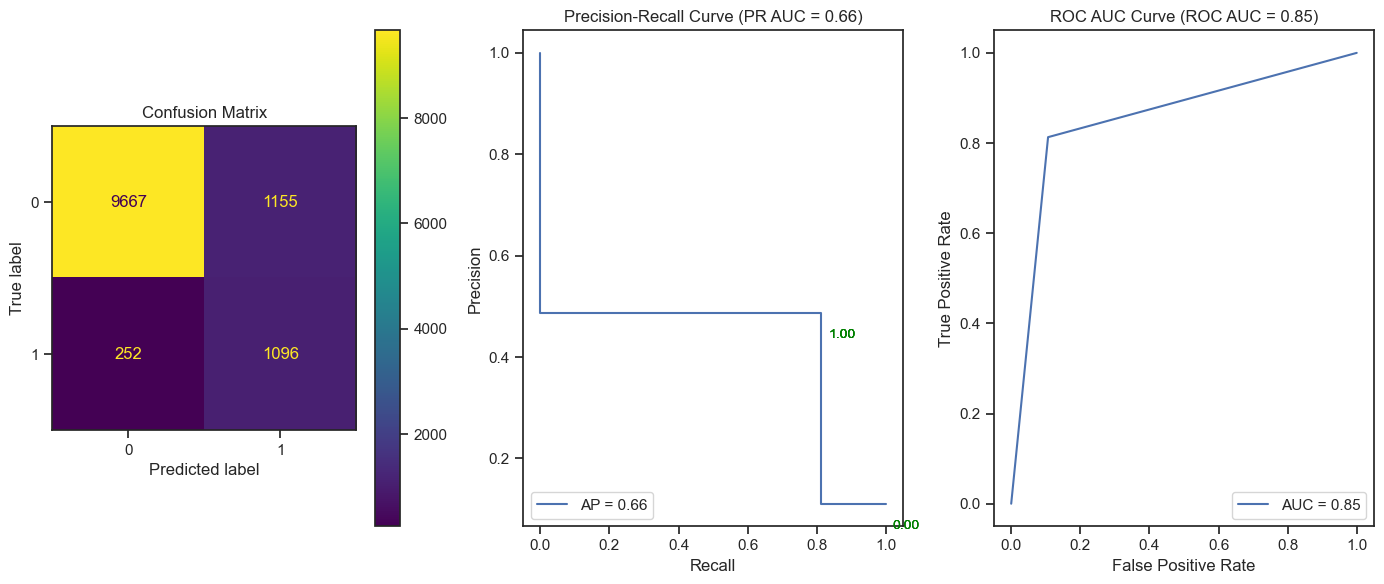

Sorted Features: 
                    Feature                  Coefficient
53                     duration^2 euribor3m   1.593642  
106                               month_mar   1.539694  
62         duration cons.conf.idx euribor3m   1.174897  
118                        poutcome_success   1.070729  
82                cons.conf.idx euribor3m^2   1.034988  
49                               duration^3   1.022066  
109                               month_oct   0.862463  
36              age duration cons.price.idx   0.574614  
76               cons.price.idx^2 euribor3m   0.570442  
58                duration cons.price.idx^2   0.567716  
80                          cons.conf.idx^3   0.548433  
24                 cons.price.idx euribor3m   0.545840  
6                                 euribor3m   0.518807  
41               age campaign cons.conf.idx   0.480893  
38                   age duration euribor3m   0.453118  
15                  duration cons.price.idx   0.424785  
8            

In [15]:
#########################################################################################
# Iteration1: Simple Model - Logistic Regression with SMOTE resample on train data
#########################################################################################

# Scoring dictionary for multiple metrics
scoring = {
    'f1': 'f1',
    'accuracy': 'accuracy'
}

# Create a pipeline for numeric features with polynomial transformation and scaling
numeric_transformer = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler())
])

# Create a ColumnTransformer that applies transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),  # Apply polynomial and scaling to numeric features
        ('cat_bin', 'passthrough', categorical_feature_names)  # Pass through already encoded features
    ]
)

# Logistic Regression model
log_reg = LogisticRegression(penalty='l2', C=0.1, solver='liblinear', random_state=43)

# Create the pipeline with the preprocessor and logistic regression
log_reg_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', log_reg)
])
log_reg_pipe.fit(X1_train, y1_train)

# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and compute multiple metrics
cv_results = cross_validate(log_reg_pipe, X1_train, y1_train, cv=skf, scoring=scoring, return_train_score=True)

# F1-score as metric
f1_scores_log_reg = cv_results['test_f1']

# Accuracy as metric
accuracy_scores_lgr = cv_results['test_accuracy']

results_lgr1 = evaluate_model(log_reg_pipe, X1_test, y1_test, 0.5)

###########################################################################################
# Get feature coefficients
###########################################################################################
# Fit the pipeline
log_reg_pipe.fit(X1_train, y1_train)

# Extract the fitted model from the pipeline
model = log_reg_pipe.named_steps['model']

# Extract the preprocessor from the pipeline
preprocessor = log_reg_pipe.named_steps['preprocessor']

# Get the feature names after polynomial transformation
numeric_transformer = preprocessor.named_transformers_['num']
poly_transformer = numeric_transformer.named_steps['poly']
poly_feature_names = poly_transformer.get_feature_names_out(input_features=num_features)

# Get the feature names for categorical and binary features (passthrough)
cat_bin_feature_names = categorical_feature_names
# print("cat feature names encoded:", cat_bin_feature_names)

# Combine feature names
feature_names = list(poly_feature_names) + list(cat_bin_feature_names)


# Create a DataFrame of feature names and their corresponding coefficients
coefficients = model.coef_.flatten()
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the features by coefficient value in descending order
sorted_features = feature_df.sort_values(by='Coefficient', ascending=False)
print("Sorted Features: ")
print(sorted_features)

# Print the top 20 positive and top 10 negative features
print("Top Features (Positive):")
print(sorted_features.head(20))

# Print the top 10 negative features (sorted in ascending order for negatives)
print("\nTop Features (Negative):")
print(sorted_features.sort_values(by='Coefficient', ascending=True).head(10))


# Conclusion: Low importance feature 'default' and Negative importance features 'housing' and 'marital' have low negative coefs.
# Confirmed that these features can be dropped too. Went back to list of dropped columns to drop these as well.

######################################################################################################
# Results: Use Linear Regression Model scores from Iteration1 and capture results in a data-frame
######################################################################################################
results_dict_lgr1 = {
    'Model': ['LogisticRegression with SMOTE on train'],
    'Average Fit Time (seconds)': [np.mean(cv_results['fit_time'])],
    'Train F1 score (cv)': [np.mean(cv_results['train_f1'])],
    'Test F1 score (cv)': [np.mean(f1_scores_log_reg)],
    'Test F1 score': results_lgr1['f1_score'],
    'Train Accuracy score (cv)': [np.mean(cv_results['train_accuracy'])],
    'Test Accuracy score (cv)' : [np.mean(accuracy_scores_lgr)],
    'Test Accuracy score'  : results_lgr1['accuracy_score'],
    'PR AUC score'         : results_lgr1['pr_auc_value'],
    'ROC AUC score'        : results_lgr1['roc_auc_value'],
    'True Positives'      : results_lgr1['true_positives'],
    'False Positives'      : results_lgr1['false_positives'],
    'True Negatives'      : results_lgr1['true_negatives'],
    'False Negatives'      : results_lgr1['false_negatives']
}

results_df_lgr1 = pd.DataFrame(results_dict_lgr1)

print("\nLogisticRegression with SMOTE on train")
print(results_df_lgr1)


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     10822
           1       0.94      0.95      0.94     10821

    accuracy                           0.94     21643
   macro avg       0.94      0.94      0.94     21643
weighted avg       0.94      0.94      0.94     21643

PR AUC Value: 0.96
ROC AUC Score: 0.94
False Positives: 692
False Negatives: 575


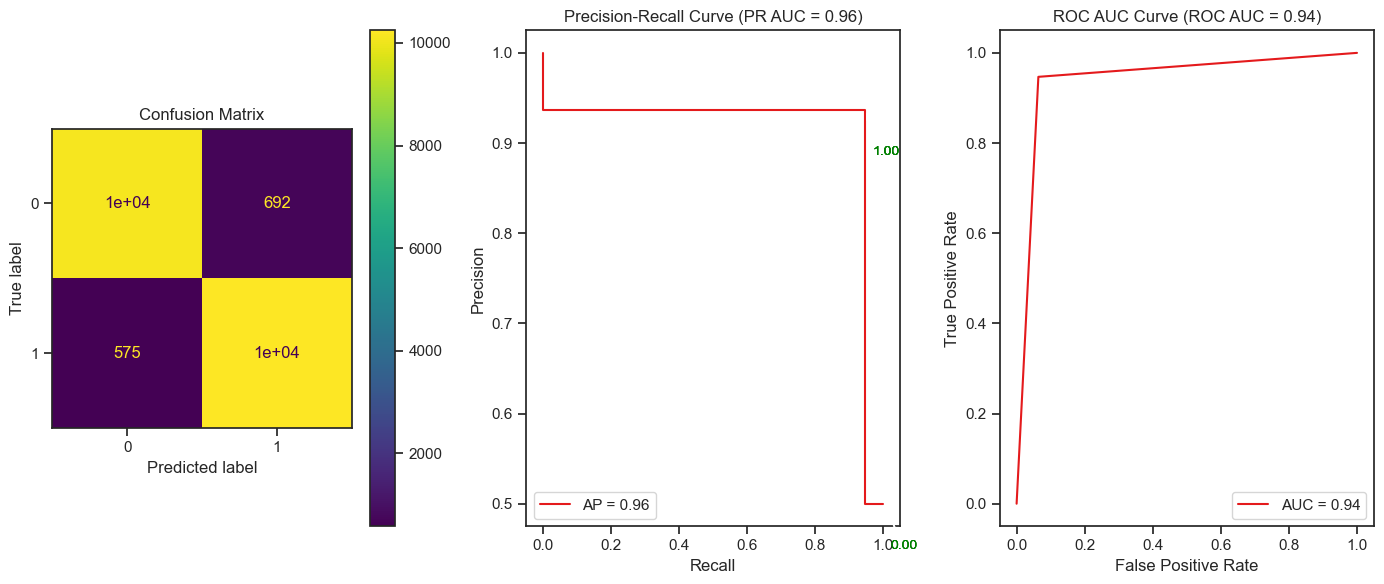


LogisticRegression with SMOTE on whole
                   Model                   Average Fit Time (seconds)  \
0  LogisticRegression with SMOTE on whole           0.714697            

   Train F1 score (cv)  Test F1 score (cv)  Test F1 score  \
0        0.93946             0.938713         0.941771      

   Train Accuracy score (cv)  Test Accuracy score (cv)  Test Accuracy score  \
0          0.939098                   0.938375               0.941459         

   PR AUC score  ROC AUC score  True Positives  False Positives  \
0    0.955082      0.941459          10246            692         

   True Negatives  False Negatives  
0       10130            575        


In [270]:
################################################################################################################
# Iteration2: Simple Model - Logistic Regression WITH SMOTE resample on whole
################################################################################################################

# Scoring dictionary for multiple metrics
scoring = {
    'f1': 'f1',
    'accuracy': 'accuracy'
}

# Polynomial transform on numerics 
numeric_transformer = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler())
])

# Create a ColumnTransformer that applies transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),  # Apply polynomial and scaling to numeric features
        ('cat_bin', 'passthrough', categorical_feature_names)  # Pass through already encoded features
    ]
)

# Logistic Regression model
log_reg_sm = LogisticRegression(penalty='l2', C=0.1, solver='liblinear', random_state=43)

# Create the pipeline with the preprocessor,and logistic regression
log_reg_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', log_reg_sm)
])
log_reg_pipe.fit(X_train, y_train)

# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and compute multiple metrics on SMOTE resampled data
cv_results = cross_validate(log_reg_pipe, X_train, y_train, cv=skf, scoring=scoring, return_train_score=True)

# F1-score as metric
f1_scores_lgr_train = cv_results['train_f1']
f1_scores_lgr = cv_results['test_f1']

# Accuracy as metric
accuracy_scores_lgr_train = cv_results['train_accuracy']
accuracy_scores_lgr = cv_results['test_accuracy']

# Fit Time as metric
fit_times = cv_results['fit_time']
avg_fit_time = np.mean(fit_times)

# Call function to get metrics PR AUC value, ROC AUC value, FP, FN
results_lgr2 = evaluate_model(log_reg_pipe, X_test, y_test, 0.5)

######################################################################################################
# Results Summary: Use Linear Regression Model scores from Iteration2 and capture results in a data-frame
######################################################################################################
results_dict_lgr2 = {
    'Model': ['LogisticRegression with SMOTE on whole'],
    'Average Fit Time (seconds)': [avg_fit_time],
    'Train F1 score (cv)': [np.mean(f1_scores_lgr_train)],
    'Test F1 score (cv)': [np.mean(f1_scores_lgr)],
    'Test F1 score': results_lgr2['f1_score'],
    'Train Accuracy score (cv)': [np.mean(cv_results['train_accuracy'])],
    'Test Accuracy score (cv)' : [np.mean(accuracy_scores_lgr)],
    'Test Accuracy score'  : results_lgr2['accuracy_score'],
    'PR AUC score'         : results_lgr2['pr_auc_value'],
    'ROC AUC score'   : results_lgr2['roc_auc_value'],
    'True Positives'      : results_lgr2['true_positives'],
    'False Positives'      : results_lgr2['false_positives'],
    'True Negatives'      : results_lgr2['true_negatives'],
    'False Negatives'      : results_lgr2['false_negatives']
}

results_df_lgr2 = pd.DataFrame(results_dict_lgr2)

print("\nLogisticRegression with SMOTE on whole")
print(results_df_lgr2)

### Problem 9: Score the Model

What is the accuracy of your model?

In [271]:
########################################################################################################################
# F1, PR AUC and Accuracy Score of Simple Linear Regression Models (Iteration1 and Iteration2)  are captured above

# Conclusion: In Iteration2, observed that the use of SMOTE on whole data-set has better F1 and PR AUC score, over 
# Iteration1. Proceeding to hyper tune Iteration2 model with Grid/RandomizedSearch based on its compute time.
########################################################################################################################

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'preprocessor__num__poly__degree': 6, 'model__penalty': 'l2', 'model__C': 1.0}

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92     10822
           1       0.44      0.87      0.59      1348

    accuracy                           0.86     12170
   macro avg       0.71      0.87      0.75     12170
weighted avg       0.92      0.86      0.88     12170

PR AUC Value: 0.67
ROC AUC Score: 0.86
False Positives: 1485
False Negatives: 170


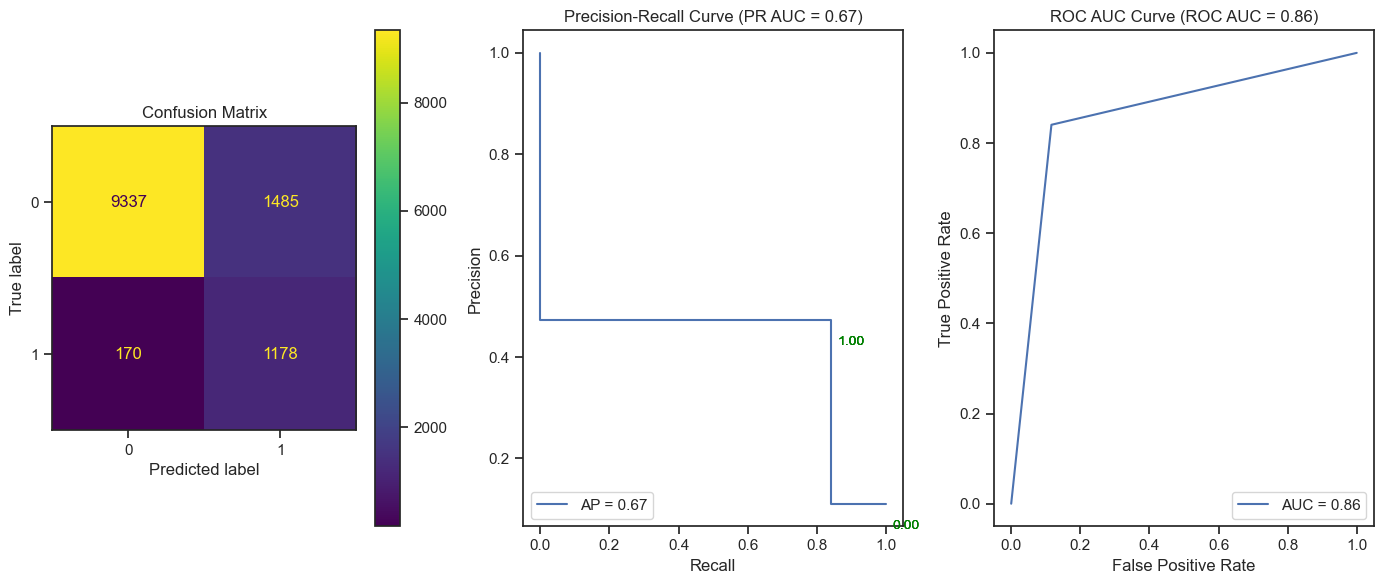

Sorted Features: 
              Feature             Coefficient
4                 cons.price.idx   2.707556  
949                    month_oct   2.433611  
917              cons.conf.idx^6   2.380486  
80               cons.conf.idx^3   1.656026  
22              cons.price.idx^2   1.593425  
..                           ...          ...
919  cons.conf.idx^4 euribor3m^2  -1.434432  
769  duration^2 cons.price.idx^4  -1.525438  
947                    month_may  -1.733885  
441             cons.price.idx^5  -1.762814  
896             cons.price.idx^6  -2.886025  

[959 rows x 2 columns]
Top Features (Positive):
                      Feature                    Coefficient
4                                cons.price.idx   2.707556  
949                                   month_oct   2.433611  
917                             cons.conf.idx^6   2.380486  
80                              cons.conf.idx^3   1.656026  
22                             cons.price.idx^2   1.593425  
958            

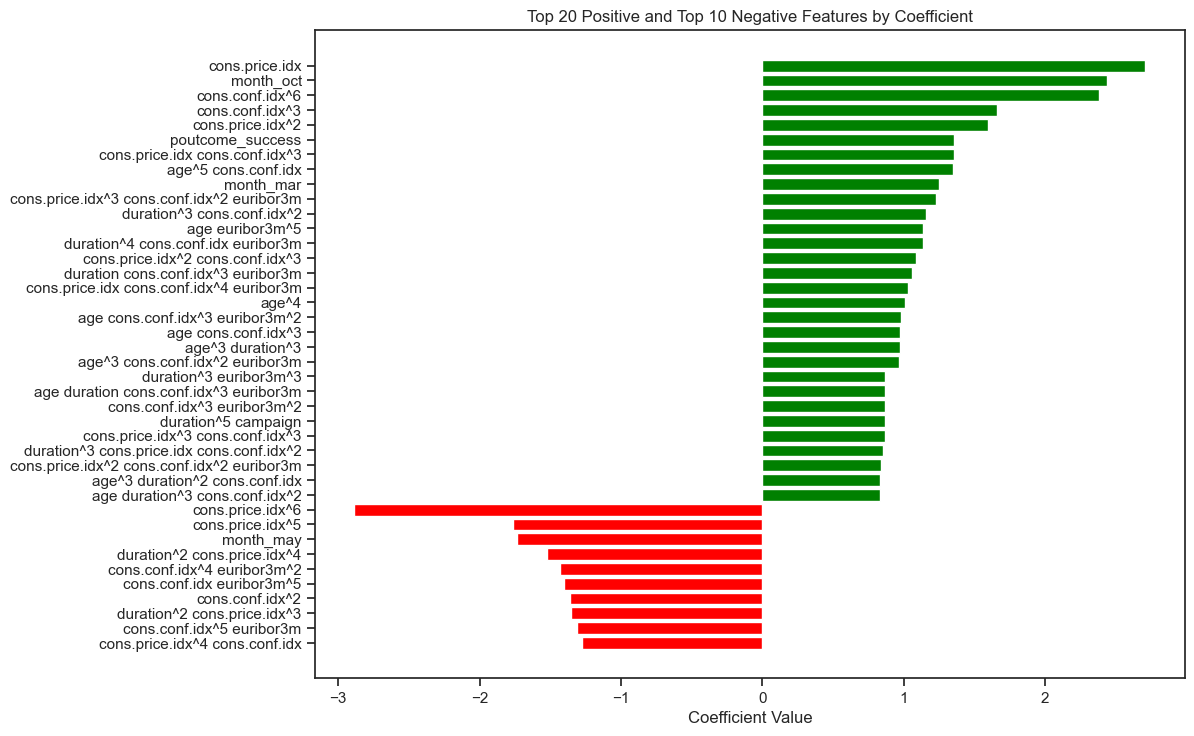


LogisticRegression with SMOTE on train (GridSearchCV)
                             Model                              \
0  LogisticRegression with SMOTE on train (RandomizedSearchCV)   

   Average Fit Time (seconds)  Train F1 score (cv)  Test F1 score (cv)  \
0           0.535854                0.846593             0.845033        

   Test F1 score  Train Accuracy score (cv)  Test Accuracy score (cv)  \
0    0.587385             0.887536                   0.886353           

   Test Accuracy score  PR AUC score  ROC AUC score  True Positives  \
0        0.86401          0.665818      0.862037          1178        

   False Positives  True Negatives  False Negatives  
0       1485             9337             170        


In [16]:
##################################################################################################
# Iteration3: Simple Model - Logistic Regression with SMOTE resample on train data. 
# HyperParam tuning with GridSearchCV to reduce false positives from Iteration1.
##################################################################################################

# Scoring dictionary for multiple metrics
scoring = {
    'f1': 'f1',
    'accuracy': 'accuracy'
}

# Create a pipeline for numeric features with polynomial transformation and scaling
numeric_transformer = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler())
])

# Create a ColumnTransformer that applies transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),  # Apply polynomial and scaling to numeric features
        ('cat_bin', 'passthrough', categorical_feature_names)  # Pass through already encoded features
    ]
)

# Logistic Regression model with class_weight=balanced to help reduce false positives
log_reg_sm = LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', random_state=43, max_iter=10000, class_weight='balanced')

# Create pipeline with the preprocessor, and logistic regression model 
log_reg_pipe_w_smote = Pipeline([
    ('preprocessor', preprocessor),
    ('model', log_reg_sm)
])

# Define parameter grid
param_grid = {
    'preprocessor__num__poly__degree': [3, 5, 6], # Polynomial degrees to test
    'model__C': [0.01, 0.1, 1.0],                 # Lower values for stronger regularization 
    'model__penalty': ['l2'],                     # Penalty norm
}

# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearch took long, switched to RandomizedSearch insteas
# Perform RandomizedSearch and compute multiple metrics
lgr_grid_search = RandomizedSearchCV(
    estimator=log_reg_pipe_w_smote,
    param_distributions=param_grid,
    n_iter=10000,
    scoring=scoring,
    refit='f1',
    cv=skf,  
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)
lgr_grid_search.fit(X1_train, y1_train)


# Get the best parameters
best_params = lgr_grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Get the best estimator
best_estimator = lgr_grid_search.best_estimator_

# Fit best model to the training data
best_estimator.fit(X1_train, y1_train)

# Get the index of the best parameter set based on F1
best_index = lgr_grid_search.best_index_

# Retrieve all keys in cv_results_ dictionary
all_param_names = lgr_grid_search.cv_results_.keys()

# print("All parameter names in cv_results_:")
# for param in all_param_names:
#   print(param)

# Get the mean fit time for the best parameter set
best_fit_time = lgr_grid_search.cv_results_['mean_fit_time'][best_index]

# Get cv train and test F1 score
train_f1 = lgr_grid_search.cv_results_['mean_train_f1'][best_index]
test_f1 = lgr_grid_search.cv_results_['mean_test_f1'][best_index]

# Get train and test accuracy score
train_accuracy = lgr_grid_search.cv_results_['mean_train_accuracy'][best_index]
test_accuracy = lgr_grid_search.cv_results_['mean_test_accuracy'][best_index]

# Get additional metrics and test scores
results_lgr3 = evaluate_model(best_estimator, X1_test, y1_test, 0.6)

###########################################################################################
# Get feature coefficients
###########################################################################################
# Extract logistic regression model from the pipeline
log_reg_model = best_estimator.named_steps['model']

# Extract the preprocessor from the pipeline
preprocessor = best_estimator.named_steps['preprocessor']

# Get the feature names after polynomial transformation
numeric_transformer = preprocessor.named_transformers_['num']
poly_transformer = numeric_transformer.named_steps['poly']
poly_feature_names = poly_transformer.get_feature_names_out(input_features=num_features)

# Get the feature names for categorical and binary features (passthrough)
cat_bin_feature_names = categorical_feature_names

# Combine feature names
feature_names = list(poly_feature_names) + list(cat_bin_feature_names)


# Create a DataFrame of feature names and their corresponding coefficients
coefficients = log_reg_model.coef_.flatten()
feature_df_new = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the features by coefficient value in descending order
sorted_features = feature_df_new.sort_values(by='Coefficient', ascending=False)
print("Sorted Features: ")
print(sorted_features)

# Print the top 20 positive and top 10 negative features
print("Top Features (Positive):")
print(sorted_features.head(20))

# Print the top 10 negative features (sorted in ascending order for negatives)
print("\nTop Features (Negative):")
print(sorted_features.sort_values(by='Coefficient', ascending=True).head(10))

top_30_positive = sorted_features.head(30)
top_20_negative = sorted_features.sort_values(by='Coefficient', ascending=True).head(10)

# Combine positive and negative features into one DataFrame
top_features = pd.concat([top_30_positive, top_20_negative])

# Plot top 20 positive and top 10 negative features
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Coefficient'], color=['green' if coef > 0 else 'red' for coef in top_features['Coefficient']])
plt.xlabel('Coefficient Value')
plt.title('Top 20 Positive and Top 10 Negative Features by Coefficient')
plt.gca().invert_yaxis()     # Invert y-axis to have the largest coefficient at the top
plt.show()


######################################################################################################
# Results: Use Linear Regression Model scores from Iteration3 and capture results in a data-frame
######################################################################################################
results_dict_lgr3 = {
    'Model': 'LogisticRegression with SMOTE on train (RandomizedSearchCV)',
    'Average Fit Time (seconds)': [np.mean(cv_results['fit_time'])],
    'Train F1 score (cv)': [train_f1],
    'Test F1 score (cv)': [test_f1],
    'Test F1 score': results_lgr3['f1_score'],
    'Train Accuracy score (cv)': [train_accuracy],
    'Test Accuracy score (cv)'   : [test_accuracy],
    'Test Accuracy score'  : results_lgr3['accuracy_score'],
    'PR AUC score'         : results_lgr3['pr_auc_value'],
    'ROC AUC score'        : results_lgr3['roc_auc_value'],
    'True Positives'       : results_lgr3['true_positives'],
    'False Positives'      : results_lgr3['false_positives'],
    'True Negatives'       : results_lgr3['true_negatives'], 
    'False Negatives'      : results_lgr3['false_negatives'] 
}

results_df_lgr3 = pd.DataFrame(results_dict_lgr3)

print("\nLogisticRegression with SMOTE on train (GridSearchCV)")
print(results_df_lgr3)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92     10822
           1       0.45      0.71      0.55      1348

    accuracy                           0.87     12170
   macro avg       0.70      0.80      0.74     12170
weighted avg       0.90      0.87      0.88     12170



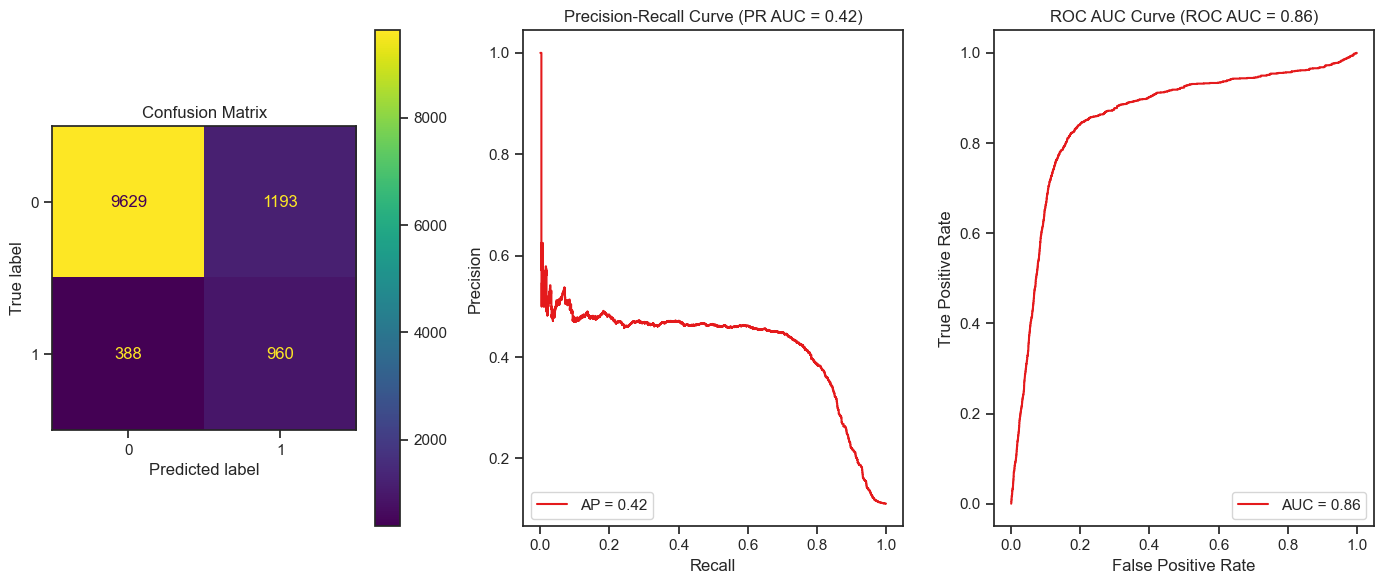


Comparison of LogisticRegression Results (Prior vs. Optimal Threshold)
                                        Model                                         \
0                        LogisticRegression with SMOTE on train (RandomizedSearchCV)   
1  LogisticRegression (RandomizedSearchCV best estimator) threshold tuned for max F1   

  Threshold  Test F1 score (at threshold)  PR AUC score  ROC AUC score  \
0       0.6            0.587385              0.665818      0.862037      
1  0.098625            0.548415              0.421287      0.856292      

   True Positives  False Positives  True Negatives  False Negatives  
0       1178            1485             9337             170        
1        960            1193             9629             388        


In [333]:
######################################################################################################
# Tuning threshold for best Logistic Regression classifier from Iteration3 based on F1 Score
######################################################################################################

# Call function to tune threshold based on f1 score
tune_results_lgr = tune_threshold_for_f1(best_estimator, X1_test, y1_test)


# Create dictionary with two rows: one from Iteration3 results and another with optimal threshold results
tune_results_dict_lgr = {
    'Model': [
        results_dict_lgr3['Model'],
        'LogisticRegression (RandomizedSearchCV best estimator) threshold tuned for max F1'
    ],
    'Threshold': [
        '0.6',
        tune_results_lgr['optimal_threshold']
    ],
    'Test F1 score (at threshold)': [
        results_dict_lgr3['Test F1 score'], 
        tune_results_lgr['max_f1_score']
    ],
    'PR AUC score': [
        results_dict_lgr3['PR AUC score'],
        tune_results_lgr['pr_auc_value']
    ],
    'ROC AUC score': [
        results_dict_lgr3['ROC AUC score'],
        tune_results_lgr['roc_auc_value']
    ],
    'True Positives': [
        results_dict_lgr3['True Positives'], 
        tune_results_lgr['true_positives']
    ],
    'False Positives': [
        results_dict_lgr3['False Positives'], 
        tune_results_lgr['false_positives']
    ],
    'True Negatives': [
        results_dict_lgr3['True Negatives'], 
        tune_results_lgr['true_negatives']
    ],
    'False Negatives': [
        results_dict_lgr3['False Negatives'], 
        tune_results_lgr['false_negatives']
    ]
}

# Convert to DataFrame
tune_results_df_lgr = pd.DataFrame(tune_results_dict_lgr)

# Display
print("\nComparison of LogisticRegression Results (Prior vs. Optimal Threshold)")
print(tune_results_df_lgr)



In [334]:
###############################################################################################
# Results Summary: All iterations of Logistic Regression model
###############################################################################################
pd.set_option('display.max_colwidth', None)
results_df = pd.concat([results_df_lgr1, results_df_lgr2, results_df_lgr3], ignore_index=True)
 
# Open file in write mode and add the title for first
with open('results/lgr_all_iterations_summary.csv', 'w') as f:
    results_df.set_index('Model', inplace=True)
    f.write('Results Summary: All iterations of Logistic Regression model\n') 
    results_df.to_csv(f, header=True)  
    f.write('\n')


tune_results_df_lgr_final = tune_results_df_lgr.copy()
# Open file in append mode and add title for second 
with open('results/lgr_all_iterations_summary.csv', 'a') as f:
    f.write('\nResults Summary: Compare LogisticRegression models with decision threshold fine tuned\n') 
    tune_results_df_lgr.set_index('Model', inplace=True)
    tune_results_df_lgr.to_csv(f, header=True)  
    f.close()



Index(['Model', 'Threshold', 'Test F1 score (at threshold)', 'PR AUC score',
       'ROC AUC score', 'True Positives', 'False Positives', 'True Negatives',
       'False Negatives'],
      dtype='object')
Index(['Threshold', 'Test F1 score (at threshold)', 'PR AUC score',
       'ROC AUC score', 'True Positives', 'False Positives', 'True Negatives',
       'False Negatives'],
      dtype='object')
Index(['Model', 'Threshold', 'Test F1 score (at threshold)', 'PR AUC score',
       'ROC AUC score', 'True Positives', 'False Positives', 'True Negatives',
       'False Negatives'],
      dtype='object')


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     10822
           1       0.93      0.94      0.93     10821

    accuracy                           0.93     21643
   macro avg       0.93      0.93      0.93     21643
weighted avg       0.93      0.93      0.93     21643

PR AUC Value: 0.95
ROC AUC Score: 0.93
False Positives: 795
False Negatives: 645


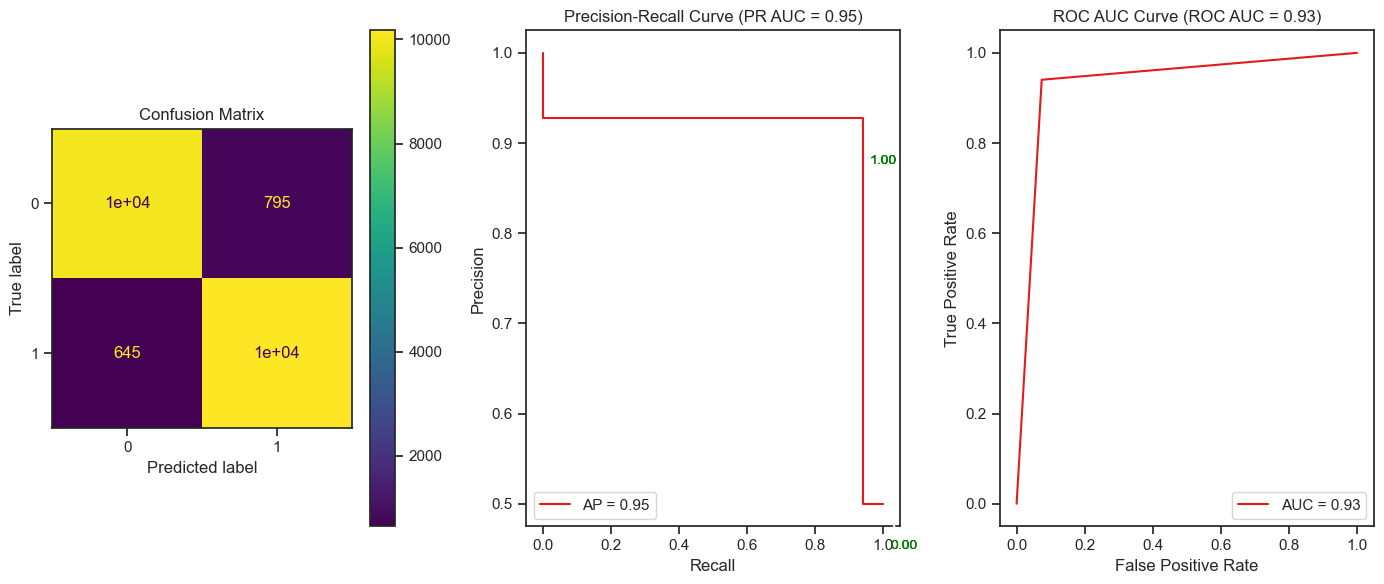


DecisionTree with SMOTE on whole
                Model                Average Fit Time (seconds)  \
0  DecisionTree with SMOTE on whole            0.18385            

   Train F1 score (cv)  Test F1 score (cv)  Test F1 score  \
0       0.999752             0.931018         0.933921      

   Train Accuracy score (cv)  Test Accuracy score (cv)  Test Accuracy score  \
0           0.93081                    0.93081               0.933466         

   PR AUC score  ROC AUC score  True Positives  False Positives  \
0    0.948739      0.933327          10176            795         

   True Negatives  False Negatives  
0       10027            645        


In [278]:
###########################################################################################################
# Iteration1: Decision Tree model with SMOTE resample on entire data-set. 
# Decision Tree classifier uses all defaults.
###########################################################################################################

# Scoring dictionary for multiple metrics
scoring = {
    'f1': 'f1',
    'accuracy': 'accuracy'
}

# Create a pipeline for numeric features with NO polynomial transformation and scaling
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create a ColumnTransformer that applies transformations
preprocessor_no_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),            # Apply scaling to numeric features
        ('cat_bin', 'passthrough', categorical_feature_names)  # Pass through already encoded features
    ]
)

# Decision Tree Classifier with all defaults
dc = DecisionTreeClassifier(random_state=43)

# Create the pipeline with the preprocessor, and DecisionTree classifier
dc_pipe = Pipeline([
    ('preprocessor', preprocessor_no_poly),
    ('model', dc)
])
dc_pipe.fit(X_train, y_train)

# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and compute multiple metrics
cv_results = cross_validate(dc_pipe, X_train, y_train, cv=skf, scoring=scoring, return_train_score=True)

# F1-score as metric
f1_scores_dc = cv_results['test_f1']
f1_scores_dc_train = cv_results['train_f1']

# Accuracy as metric
accuracy_scores_dc = cv_results['test_accuracy']
accuracy_scores_dc_train = cv_results['test_accuracy']

# Fit time as metric
fit_times = cv_results['fit_time']
avg_fit_time = np.mean(fit_times)


# Call function to get metrics Classification Report, PR AUC value, ROC AUC value, FP, FN
results = evaluate_model(dc_pipe, X_test, y_test, 0.5)


######################################################################################################
# Results Summary: Use Decision Tree Classifier scores and capture results in a data-frame
######################################################################################################
results_dict_dc = {
    'Model': 'DecisionTree with SMOTE on whole',
    'Average Fit Time (seconds)': [avg_fit_time],
    'Train F1 score (cv)': [np.mean(f1_scores_dc_train)],
    'Test F1 score (cv)': [np.mean(f1_scores_dc)],
    'Test F1 score': results['f1_score'],
    'Train Accuracy score (cv)': [np.mean(accuracy_scores_dc_train)],
    'Test Accuracy score (cv)' : [np.mean(accuracy_scores_dc)],
    'Test Accuracy score'  : results['accuracy_score'],
    'PR AUC score'        : results['pr_auc_value'],
    'ROC AUC score'       : results['roc_auc_value'],
    'True Positives'      : results['true_positives'],
    'False Positives'     : results['false_positives'],
    'True Negatives'      : results['true_negatives'],
    'False Negatives'     : results['false_negatives']
}

pd.set_option('display.max_colwidth', None)
results_df_dc = pd.DataFrame(results_dict_dc)

print("\nDecisionTree with SMOTE on whole")
print(results_df_dc)



Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     10822
           1       0.48      0.50      0.49      1348

    accuracy                           0.89     12170
   macro avg       0.71      0.72      0.71     12170
weighted avg       0.89      0.89      0.89     12170

PR AUC Value: 0.52
ROC AUC Score: 0.72
False Positives: 723
False Negatives: 676


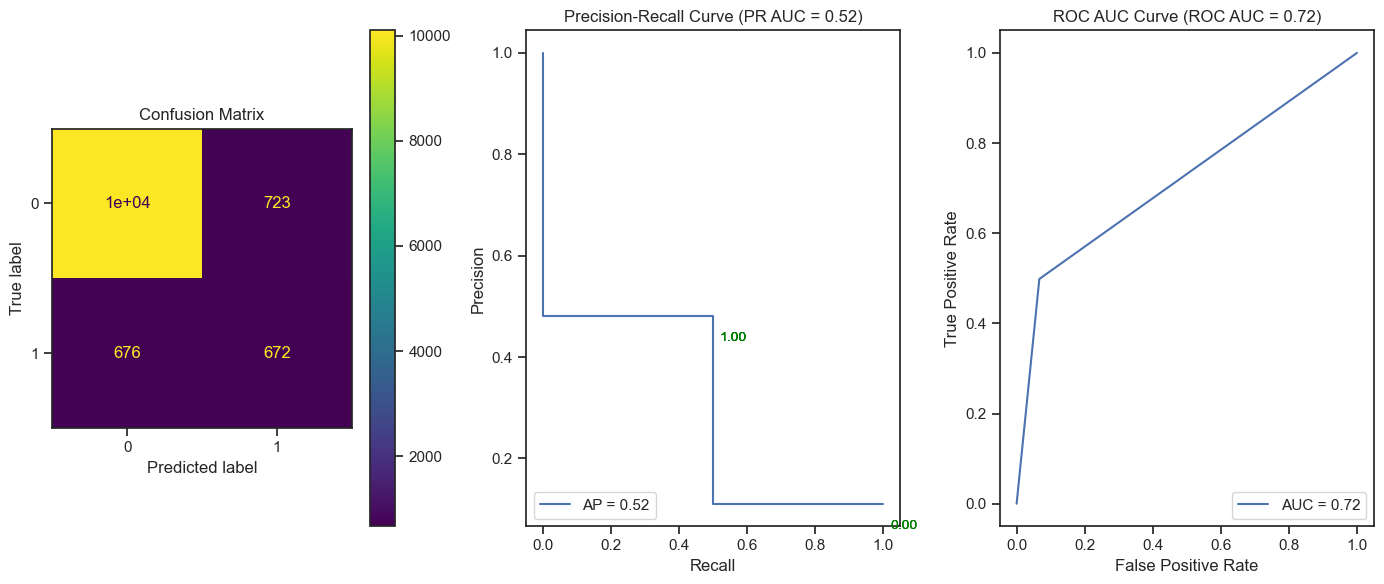


DecisionTree with SMOTE on train
                Model                Average Fit Time (seconds)  \
0  DecisionTree with SMOTE on train           0.148196            

   Train F1 score (cv)  Test F1 score (cv)  Test F1 score  \
0        0.99952             0.876694         0.489974      

   Train Accuracy score (cv)  Test Accuracy score (cv)  Test Accuracy score  \
0          0.917674                   0.917674               0.885045         

   PR AUC score  ROC AUC score  True Positives  False Positives  \
0    0.517892      0.715854           672             723         

   True Negatives  False Negatives  
0       10099            676        


In [19]:
###########################################################################################################
# Iteration2: Decision Tree model with SMOTE resample on train data. Decision Tree classifier uses all defaults.
###########################################################################################################

# Scoring dictionary for multiple metrics
scoring = {
    'f1': 'f1',
    'accuracy': 'accuracy'
}

# Create a pipeline for numeric features with scaling
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create a ColumnTransformer that applies transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),            # Apply scaling to numeric features
        ('cat_bin', 'passthrough', categorical_feature_names)  # Pass through already encoded features
    ]
)
# Decision Tree Classifier
dc = DecisionTreeClassifier(random_state=43)

# Create the pipeline with the preprocessor, SMOTE, and Decision Tree
dc_pipe_w_smote = Pipeline([
    ('preprocessor', preprocessor),
    ('model', dc)
])
dc_pipe_w_smote.fit(X1_train, y1_train)

# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and compute multiple metrics
cv_results = cross_validate(dc_pipe_w_smote, X1_train, y1_train, cv=skf, scoring=scoring, return_train_score=True)

# F1-score as metric
f1_scores_dc = cv_results['test_f1']
f1_scores_dc_train = cv_results['train_f1']

# Accuracy as metric
accuracy_scores_dc = cv_results['test_accuracy']
accuracy_scores_dc_train = cv_results['test_accuracy']

# Fit time as metric
fit_times = cv_results['fit_time']
avg_fit_time = np.mean(fit_times)


# Call the function to get metrics PR AUC value, ROC AUC value, FP, FN
metrics = evaluate_model(dc_pipe_w_smote, X1_test, y1_test, 0.6)

######################################################################################################
# Results Summary: Use Decision Tree Classifier scores and capture results in a data-frame
######################################################################################################
results_dict_dc2 = {
    'Model': ['DecisionTree with SMOTE on train'],
    'Average Fit Time (seconds)': [avg_fit_time],
    'Train F1 score (cv)': [np.mean(f1_scores_dc_train)],
    'Test F1 score (cv)': [np.mean(f1_scores_dc)],
    'Test F1 score': metrics['f1_score'],
    'Train Accuracy score (cv)': [np.mean(accuracy_scores_dc_train)],
    'Test Accuracy score (cv)' : [np.mean(accuracy_scores_dc)],
    'Test Accuracy score'  : metrics['accuracy_score'],
    'PR AUC score'         : metrics['pr_auc_value'],
    'ROC AUC score'        : metrics['roc_auc_value'],
    'True Positives'       : metrics['true_positives'],
    'False Positives'      : metrics['false_positives'],
    'True Negatives'       : metrics['true_negatives'],
    'False Negatives'      : metrics['false_negatives']
}

results_df_dc2 = pd.DataFrame(results_dict_dc2)

print("\nDecisionTree with SMOTE on train")
print(results_df_dc2)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
All feature names from the best estimator's preprocessor:
['age', 'duration', 'campaign', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'education_basic.4y', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_professional.course', 'education_university.degree', 'education_unknown', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'month_apr', 'month_aug', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success']
Best Parameters: {'model__criterion': 'gini', 'model__max_depth': 7, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2}

Classification Report:
   

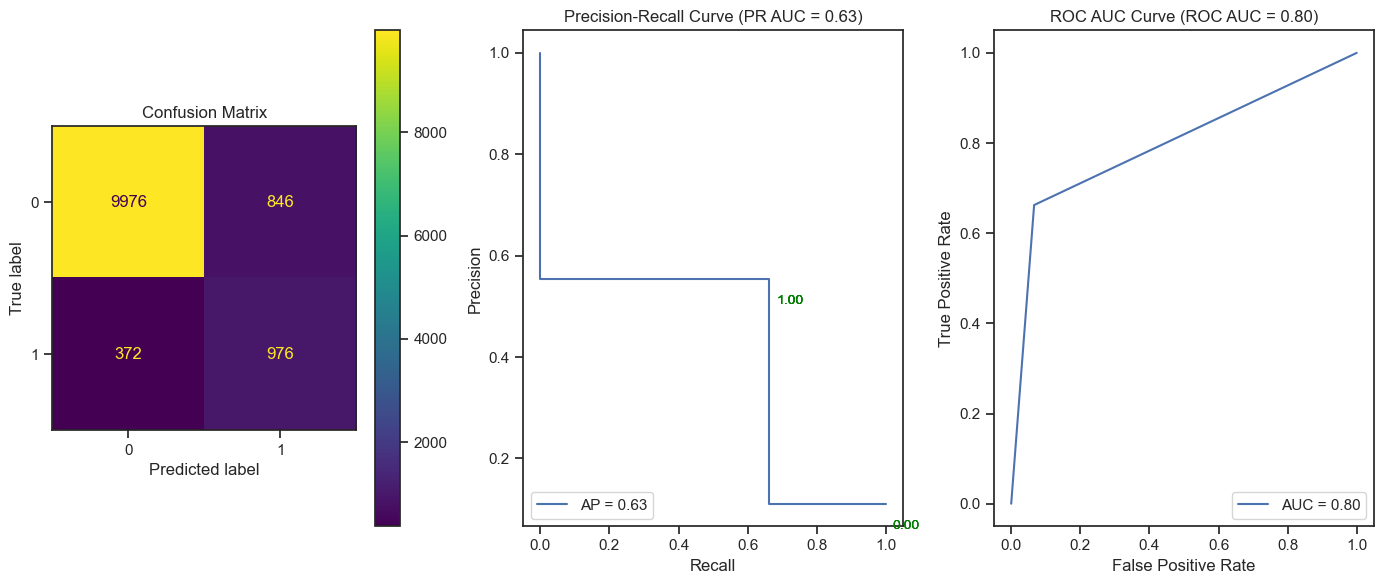

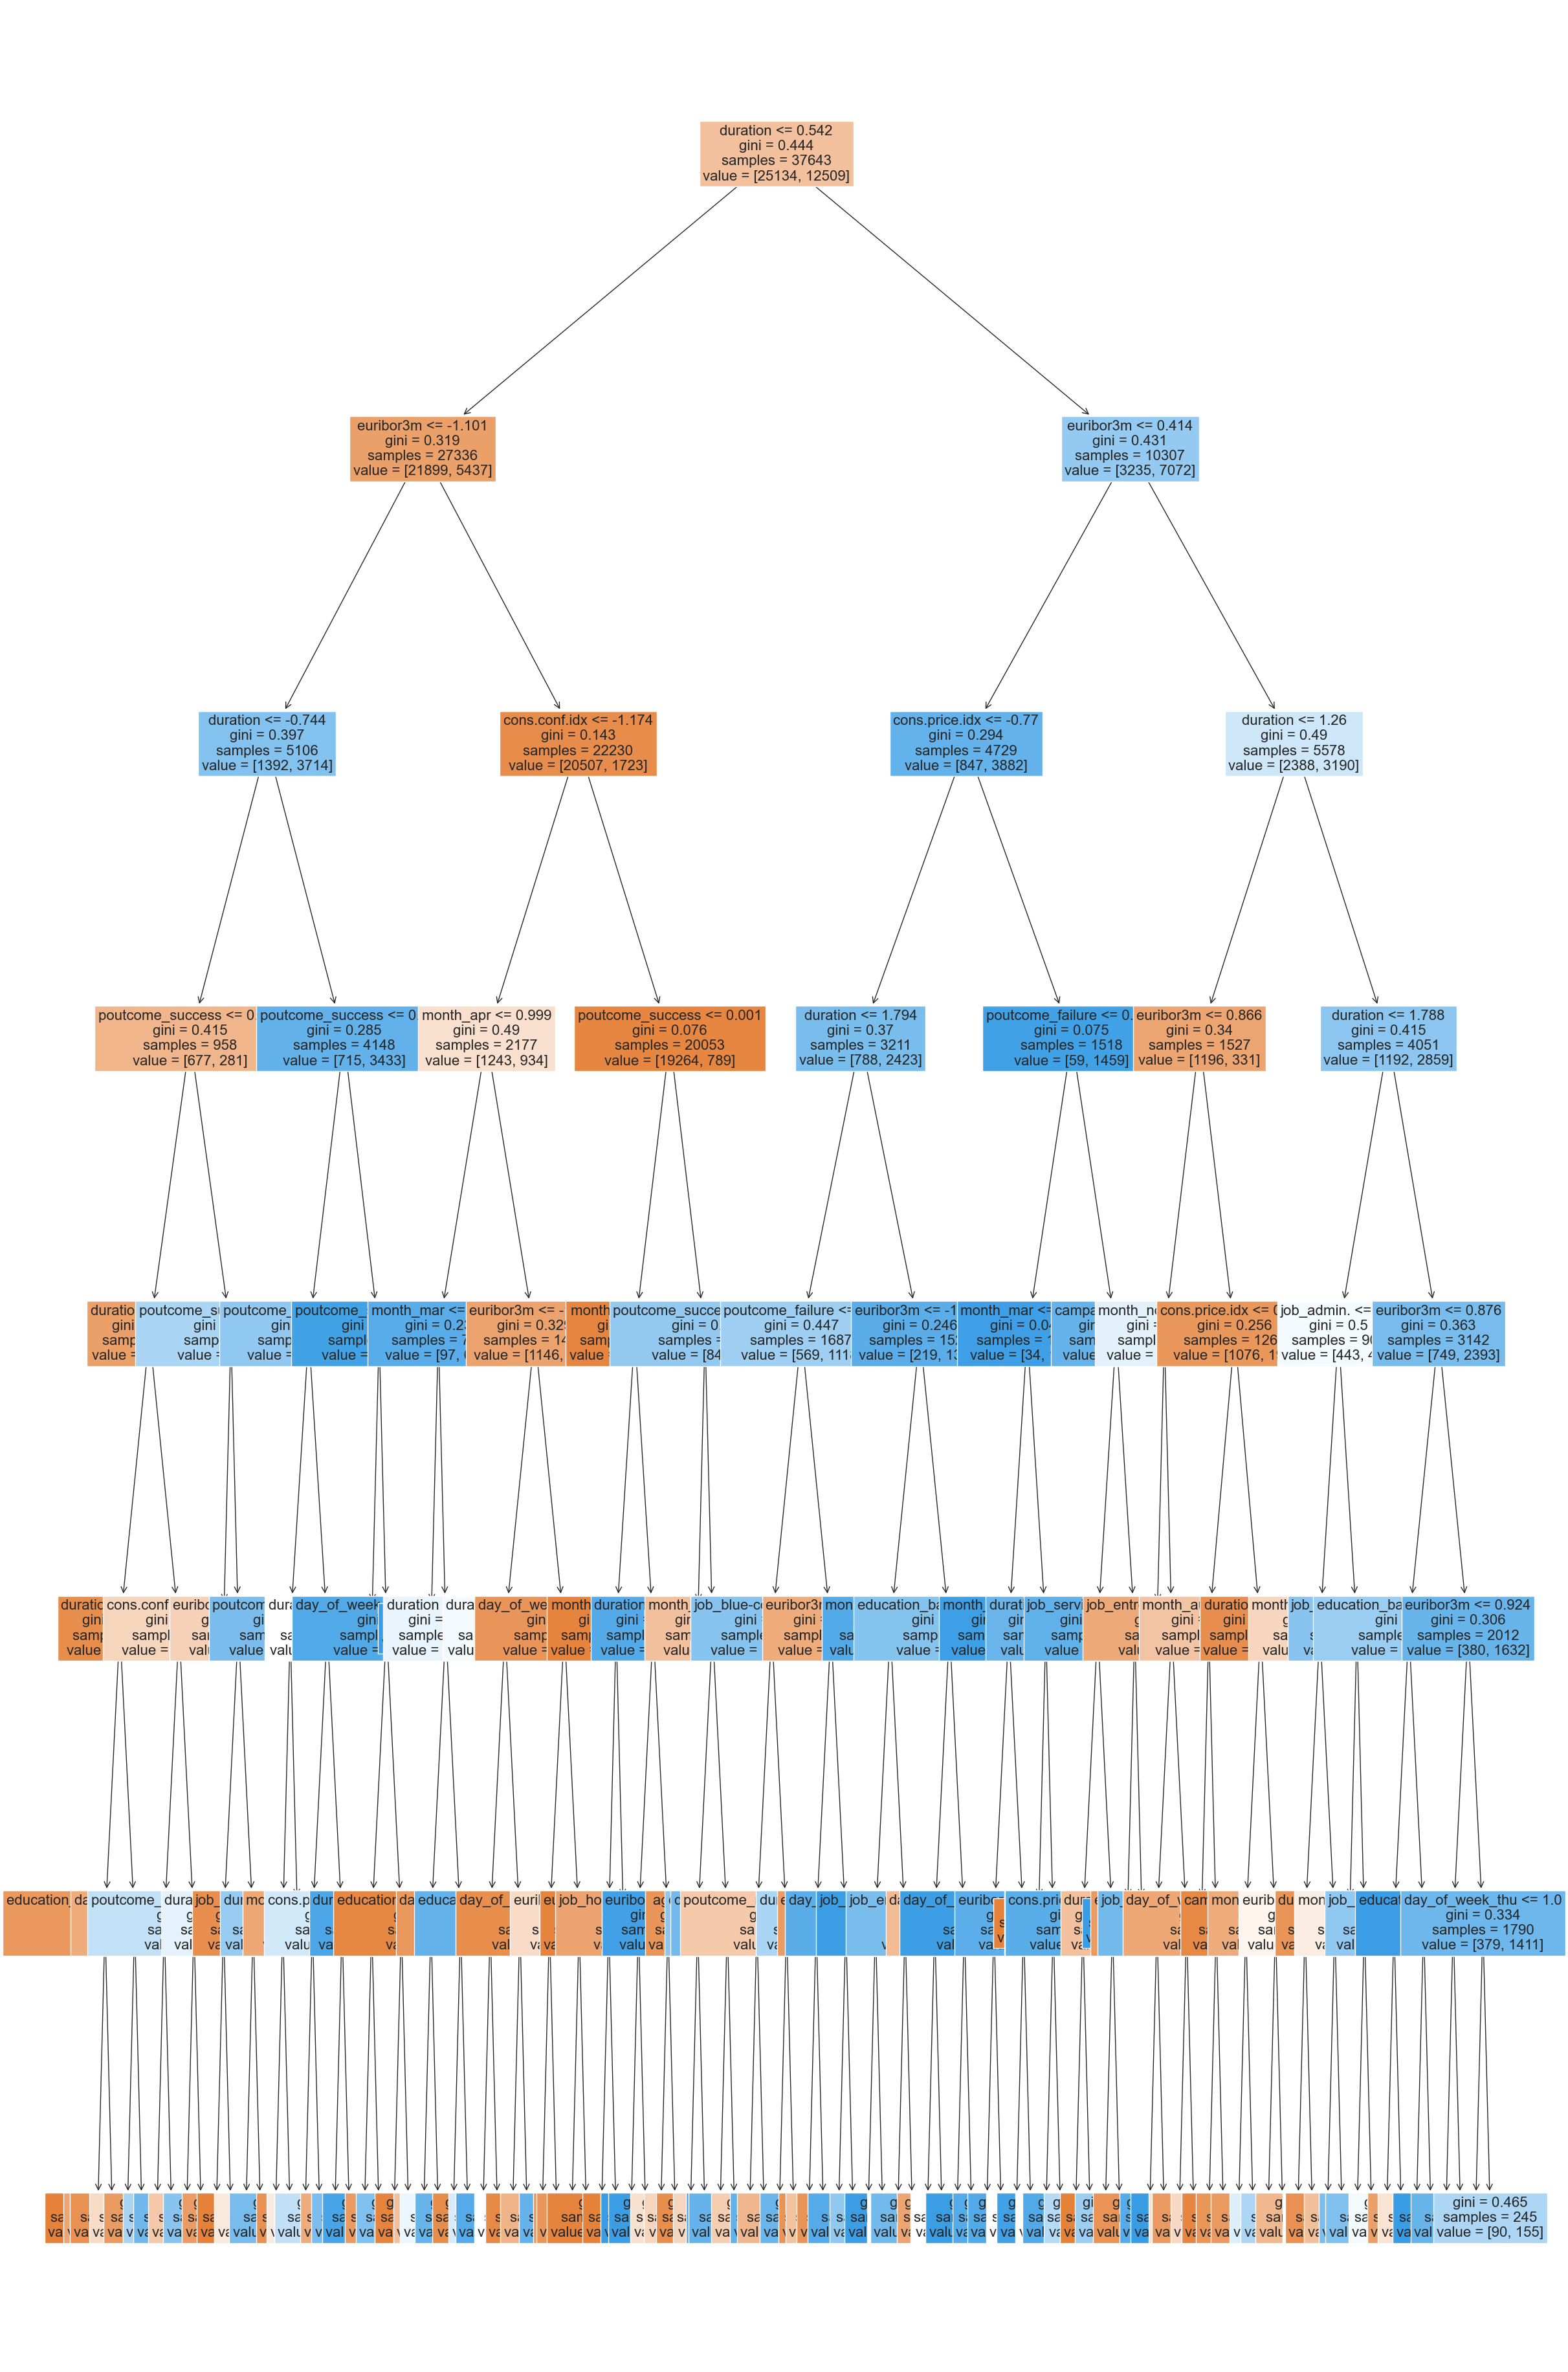


DecisionTree with SMOTE on train (GridSearchCV)
                       Model                        \
0  DecisionTree with SMOTE on train (GridSearchCV)   

   Average Fit Time (seconds)  Train F1 score (cv)  Test F1 score (cv)  \
0           0.104015                 0.87758             0.864618        

   Test F1 score  Train Accuracy score (cv)  Test Accuracy score (cv)  \
0    0.615773             0.917475                   0.908881           

   Test Accuracy score  PR AUC score  ROC AUC score  True Positives  \
0       0.899918          0.627082      0.798058           976        

   False Positives  True Negatives  False Negatives  
0        846             9976             372        


In [20]:
###########################################################################################################
# Iteration3: Decision Tree model with SMOTE on train. HyperParameter tuning with GridSearchCV.
###########################################################################################################

# Define scoring metrics 
scoring = {
    'f1': 'f1',
    'accuracy': 'accuracy',
}

# Define the parameter grid for GridSearchCV 
params = {
    'model__max_depth': range(4, 8),  
    'model__min_samples_split': range(2, 4),
    'model__criterion': ['gini', 'entropy'],
    'model__min_samples_leaf': [2, 4]
}

# Initialize GridSearchCV with multiple metrics and refit on 'f1'
dc_grid = GridSearchCV(estimator=dc_pipe_w_smote, param_grid=params, cv=skf, 
                       scoring=scoring, refit='f1', verbose=1, 
                       n_jobs=-1, return_train_score=True)
# dc_grid = RandomizedSearchCV(estimator=dc_pipe_w_smote, param_distributions=params, n_iter=10,  
#                            cv=skf, scoring=scoring, verbose=1, refit='f1', n_jobs=-1, random_state=42, 
#                            return_train_score=True)

# Fit the model
dc_grid.fit(X1_train, y1_train)

# Access the best estimator based on F1 score
best_estimator = dc_grid.best_estimator_

# Fit with best estimator 
best_estimator.fit(X1_train, y1_train)

# Extract the preprocessor from the best pipeline
preprocessor = best_estimator.named_steps['preprocessor']

# Numeric feature names after scaling
numeric_feature_names = num_features  # Scaling doesn't change the feature names

# Categorical feature names (these are passed through, so they remain unchanged)
categorical_feature_names = categorical_feature_names

# Combine numeric and categorical feature names
all_feature_names = numeric_feature_names + categorical_feature_names

# Print all feature names
print("All feature names from the best estimator's preprocessor:")
print(all_feature_names)

# Get the best parameters
best_params = dc_grid.best_params_

# Get the index of the best parameter set based on F1
best_index = dc_grid.best_index_

# Retrieve all keys in the cv_results_ dictionary
all_param_names = dc_grid.cv_results_.keys()

# print("All parameter names in cv_results_:")
# for param in all_param_names:
#    print(param)
    
# Get the mean fit time for the best parameter set
best_fit_time = dc_grid.cv_results_['mean_fit_time'][best_index]

# Get the train and test F1 score
cv_train_f1 = dc_grid.cv_results_['mean_train_f1'][best_index]
cv_test_f1 = dc_grid.cv_results_['mean_test_f1'][best_index]

# Get the train and test accuracy score
cv_train_accuracy = dc_grid.cv_results_['mean_train_accuracy'][best_index]
cv_test_accuracy = dc_grid.cv_results_['mean_test_accuracy'][best_index]


# Print best parameters and best scores
print(f"Best Parameters: {best_params}")

# Get metrics by calling function - fp, fn, single PR AUC and ROC AUC values
metrics = evaluate_model(best_estimator, X1_test, y1_test, 0.6)

# Plot the decision tree of the best estimator
fig, ax = plt.subplots(figsize=(25, 45))  # Larger plot size for better readability
tree2 = dc_grid.best_estimator_.named_steps['model']

plot_tree(tree2, 
          feature_names=all_feature_names, 
          filled=True, 
          ax=ax, 
          fontsize=16)  # Increase fontsize to make labels more readable

# Show the plot
plt.show()
######################################################################################################
# Results Summary: Use best Decision Tree Classifier from GridSearch and capture results in a data-frame
######################################################################################################
results_dict_dc3 = {
    'Model': 'DecisionTree with SMOTE on train (GridSearchCV)',
    'Average Fit Time (seconds)': [best_fit_time],
    'Train F1 score (cv)': [cv_train_f1],
    'Test F1 score (cv)' : [cv_test_f1],
    'Test F1 score'      : metrics['f1_score'],
    'Train Accuracy score (cv)': [cv_train_accuracy],
    'Test Accuracy score (cv)': [cv_test_accuracy],
    'Test Accuracy score'      : metrics['accuracy_score'],
    'PR AUC score'         : metrics['pr_auc_value'],
    'ROC AUC score'        : metrics['roc_auc_value'],
    'True Positives'       : metrics['true_positives'],
    'False Positives'      : metrics['false_positives'],
    'True Negatives'       : metrics['true_negatives'],
    'False Negatives'      : metrics['false_negatives']
}

results_df_dc3 = pd.DataFrame(results_dict_dc3)

print("\nDecisionTree with SMOTE on train (GridSearchCV)")
print(results_df_dc3)


Top Features from best estimator Decision Tree model of Iteration3
              Feature              Importance
1                        duration   0.410174 
5                       euribor3m   0.346187 
24                      month_apr   0.051186 
4                   cons.conf.idx   0.050810 
40               poutcome_success   0.045464 
31                      month_oct   0.016377 
38               poutcome_failure   0.015914 
3                  cons.price.idx   0.010025 
13                     job_admin.   0.008554 
30                      month_nov   0.006085 
28                      month_mar   0.005609 
34                day_of_week_mon   0.004946 
14                job_blue-collar   0.004773 
25                      month_aug   0.004439 
27                      month_jun   0.002550 
37                day_of_week_wed   0.002314 
36                day_of_week_tue   0.002284 
29                      month_may   0.001924 
39           poutcome_nonexistent   0.001809 
15           

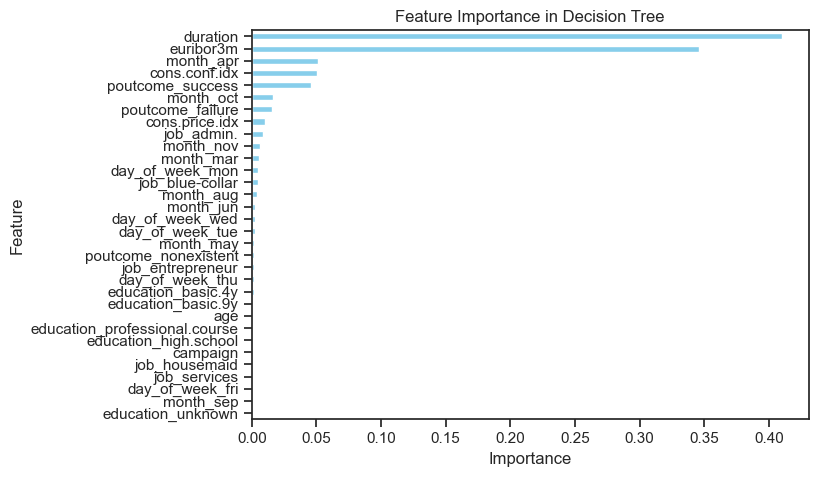

In [362]:
######################################################################################################
# Get Features used by the hyper parameter tuned Decision Tree model from Iteration3
######################################################################################################
# Get feature importances from the best estimator Decision Tree
feature_importances = best_estimator.named_steps['model'].feature_importances_

# Create a DataFrame to display feature names along with their importance scores
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Filter out features with importance of 0 or less
importance_df = importance_df[importance_df['Importance'] > 0]

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top features
print("Top Features from best estimator Decision Tree model of Iteration3")
print(importance_df)

# Plot the top features
ax = importance_df.plot(kind='barh', x='Feature', y='Importance', legend=False, color='skyblue')


plt.title('Feature Importance in Decision Tree')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Invert y-axis to show top features at the top
plt.gca().invert_yaxis()

# Display the plot
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92     10822
           1       0.45      0.71      0.55      1348

    accuracy                           0.87     12170
   macro avg       0.70      0.80      0.74     12170
weighted avg       0.90      0.87      0.88     12170



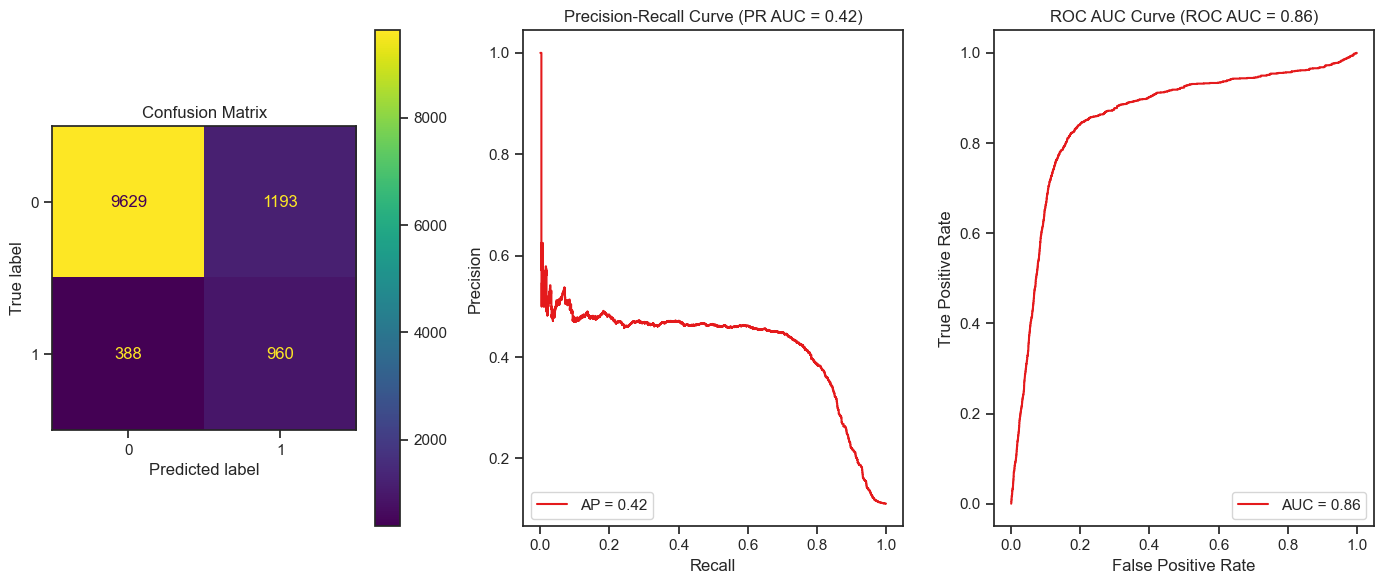


Comparison of DecisionTree Results (Prior vs. Optimal Threshold)
                                  Model                                   \
0                        DecisionTree with SMOTE on train (GridSearchCV)   
1  DecisionTree (GridSearchCV best estimator) threshold tuned for max F1   

  Threshold  Test F1 score (at threshold)  PR AUC score  ROC AUC score  \
0       0.6            0.615773              0.627082      0.798058      
1  0.098625            0.548415              0.421287      0.856292      

   True Positives  False Positives  True Negatives  False Negatives  
0        976             846             9976             372        
1        960            1193             9629             388        


In [336]:
######################################################################################################
# Tuning threshold for Decision Tree classifier from Iteration3
######################################################################################################

# Call function to tune threshold based on f1 score
tune_results_dc = tune_threshold_for_f1(best_estimator, X1_test, y1_test)


# Create dictionary with two rows: one from Iteration3 results and another with optimal threshold results
tune_results_dict_dc = {
    'Model': [
        results_dict_dc3['Model'],
        'DecisionTree (GridSearchCV best estimator) threshold tuned for max F1'
    ],
    'Threshold': [
        '0.6',
        tune_results_dc['optimal_threshold']
    ],
    'Test F1 score (at threshold)': [
        results_dict_dc3['Test F1 score'], 
        tune_results_dc['max_f1_score']
    ],
    'PR AUC score': [
        results_dict_dc3['PR AUC score'],
        tune_results_dc['pr_auc_value']
    ],
    'ROC AUC score': [
        results_dict_dc3['ROC AUC score'],
        tune_results_dc['roc_auc_value']
    ],
    'True Positives': [
        results_dict_dc3['True Positives'], 
        tune_results_dc['true_positives']
    ],
    'False Positives': [
        results_dict_dc3['False Positives'], 
        tune_results_dc['false_positives']
    ],
    'True Negatives': [
        results_dict_dc3['True Negatives'], 
        tune_results_dc['true_negatives']
    ],
    'False Negatives': [
        results_dict_dc3['False Negatives'], 
        tune_results_dc['false_negatives']
    ]
}

# Convert to DataFrame
tune_results_df_dc = pd.DataFrame(tune_results_dict_dc)

# Display
print("\nComparison of DecisionTree Results (Prior vs. Optimal Threshold)")
print(tune_results_df_dc)


In [337]:
###############################################################################################
# Results Summary: All iterations of Decision Tree Classifier model
###############################################################################################
pd.set_option('display.max_colwidth', None)
results_df = pd.concat([results_df_dc2, results_df_dc, results_df_dc3], ignore_index=True)

# Open file in write mode and add the title for first
with open('results/dc_all_iterations_summary.csv', 'w') as f:
    results_df.set_index('Model', inplace=True)
    f.write('Results Summary: All iterations of Logistic Regression model\n') 
    results_df.to_csv(f, header=True)  
    f.write('\n')

tune_results_df_dc_final = tune_results_df_dc.copy()

# Open file in append mode and add title for second 
with open('results/dc_all_iterations_summary.csv', 'a') as f:
    f.write('\nResults Summary: Compare DecisionTree models with decision threshold fine tuned\n') 
    tune_results_df_dc.set_index('Model', inplace=True)
    tune_results_df_dc.to_csv(f, header=True)  
    f.close()


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93     10822
           1       0.91      0.97      0.94     10821

    accuracy                           0.94     21643
   macro avg       0.94      0.94      0.94     21643
weighted avg       0.94      0.94      0.94     21643

PR AUC Value: 0.95
ROC AUC Score: 0.94
False Positives: 1033
False Negatives: 343


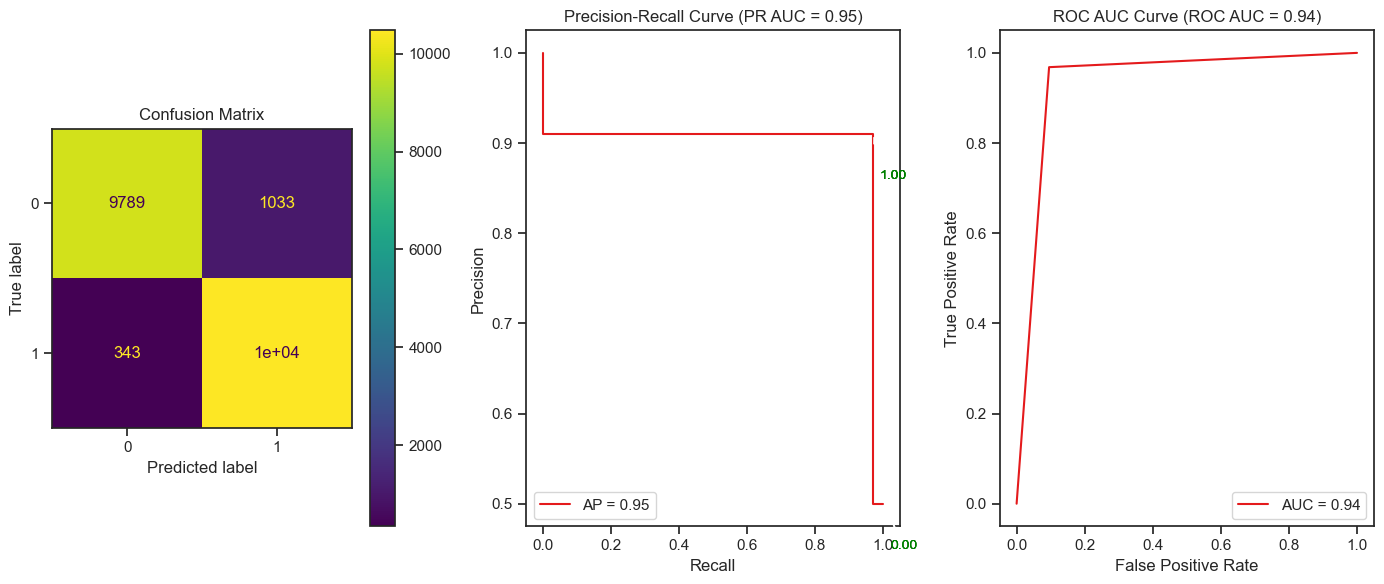


KNN with SMOTE on whole
           Model            Average Fit Time (seconds)  Train F1 score (cv)  \
0  KNN with SMOTE on whole           0.018078                0.950714         

   Test F1 score (cv)  Test F1 score  Train Accuracy score (cv)  \
0       0.934101         0.938384             0.949464            

   Test Accuracy score (cv)  Test Accuracy score  PR AUC score  ROC AUC score  \
0          0.931741               0.936423          0.947205      0.936424      

   True Positives  False Positives  True Negatives  False Negatives  
0       10478           1033             9789             343        


In [283]:
###########################################################################################################
# Iteration1: KNN Classifier with n_neighbors = 5, metric = 'minkowski'. This uses SMOTE resampling 
# on entire data-set.
###########################################################################################################

# Create a pipeline for numeric features with scaling
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create a ColumnTransformer that applies transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),            # Apply scaling to numeric features
        ('cat_bin', 'passthrough', categorical_feature_names)  # Pass through already encoded features
    ]
)

# KNN Pipeline
knn_pipe = Pipeline([('preprocessor', preprocessor), 
                     ('model', KNeighborsClassifier(metric='minkowski', n_neighbors=5))])
knn_pipe.fit(X_train, y_train)

# Scoring dictionary for multiple metrics
scoring = {
    'f1': 'f1',
    'accuracy': 'accuracy'
}

# Perform cross-validation and compute multiple metrics
cv_results = cross_validate(knn_pipe, X_train, y_train, cv=5, scoring=scoring, return_train_score=True)

# Extract and print cv F1 scores
f1_scores_knn_train = cv_results['train_f1']
f1_scores_knn = cv_results['test_f1']

# Extract and print cv accuracy scores
accuracy_scores_knn_train = cv_results['train_accuracy']
accuracy_scores_knn = cv_results['test_accuracy']

# Fit time as metric
fit_times = cv_results['fit_time']
avg_fit_time = np.mean(fit_times)

# Call the function to get metrics PR AUC value, ROC AUC value, FP, FN
metrics = evaluate_model(knn_pipe, X_test, y_test, 0.5)
######################################################################################################
# Results Summary: Use KNN scores and capture results in a data-frame
######################################################################################################
results_dict_knn = {
    'Model': 'KNN with SMOTE on whole',
    'Average Fit Time (seconds)': [avg_fit_time],
    'Train F1 score (cv)': [np.mean(f1_scores_knn_train)],
    'Test F1 score (cv)': [np.mean(f1_scores_knn)],
    'Test F1 score': metrics['f1_score'],
    'Train Accuracy score (cv)': [np.mean(accuracy_scores_knn_train)],
    'Test Accuracy score (cv)' : [np.mean(accuracy_scores_knn)],
    'Test Accuracy score'      : metrics['accuracy_score'],
    'PR AUC score'        : metrics['pr_auc_value'],
    'ROC AUC score'       : metrics['roc_auc_value'],
    'True Positives'      : metrics['true_positives'],
    'False Positives'     : metrics['false_positives'],
    'True Negatives'      : metrics['true_negatives'],
    'False Negatives'     : metrics['false_negatives']
}

pd.set_option('display.max_colwidth', None)
results_df_knn = pd.DataFrame(results_dict_knn)

print("\nKNN with SMOTE on whole")
print(results_df_knn)



Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92     10822
           1       0.44      0.71      0.54      1348

    accuracy                           0.87     12170
   macro avg       0.70      0.80      0.73     12170
weighted avg       0.90      0.87      0.88     12170

PR AUC Value: 0.59
ROC AUC Score: 0.80
False Positives: 1215
False Negatives: 388


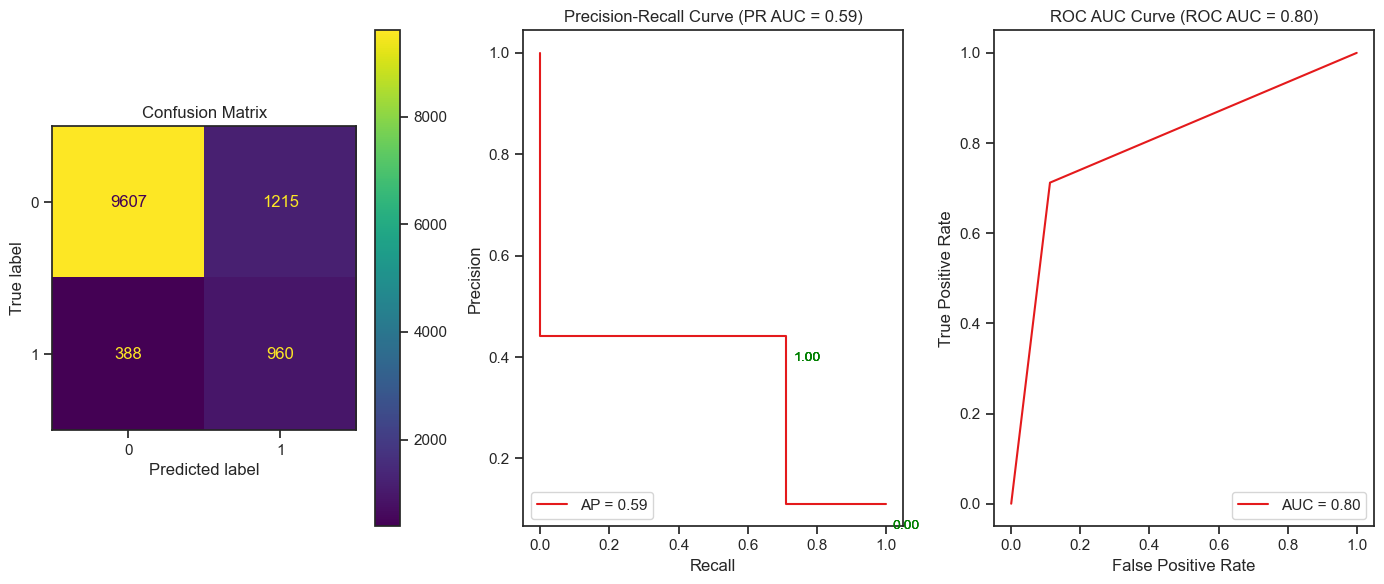


KNN with SMOTE on train
           Model            Average Fit Time (seconds)  Train F1 score (cv)  \
0  KNN with SMOTE on train            0.01276                0.905845         

   Test F1 score (cv)  Test F1 score  Train Accuracy score (cv)  \
0       0.870163          0.54499             0.932996            

   Test Accuracy score (cv)  Test Accuracy score  PR AUC score  ROC AUC score  \
0          0.906198               0.868283          0.592714      0.799947      

   True Positives  False Positives  True Negatives  False Negatives  
0        960            1215             9607             388        


In [284]:
###########################################################################################################
# Iteration2: KNN Classifier with defaults n_neighbors = 5, metric = 'minkowski'. 
# This uses SMOTE resampling with train data.
###########################################################################################################

# Scoring dictionary for multiple metrics
scoring = {
    'f1': 'f1',
    'accuracy': 'accuracy'
}

# Create a pipeline for numeric features with scaling
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create a ColumnTransformer that applies transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),            # Apply scaling to numeric features
        ('cat_bin', 'passthrough', categorical_feature_names)  # Pass through already encoded features
    ]
)

# KNN Classifier with defaults
knn_default = KNeighborsClassifier(metric='minkowski', n_neighbors=5)

# Create the pipeline with the preprocessor, SMOTE, and Decision Tree
knn_pipe_w_smote = Pipeline([
    ('preprocessor', preprocessor),
    ('model', knn_default)
])
knn_pipe_w_smote.fit(X1_train, y1_train)

# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and compute multiple metrics
cv_results = cross_validate(knn_pipe_w_smote, X1_train, y1_train, cv=5, scoring=scoring, return_train_score=True)

# Extract and print the cv F1 scores
f1_scores_knn_train = cv_results['train_f1']
f1_scores_knn = cv_results['test_f1']

# Extract and print the cv accuracy scores
accuracy_scores_knn_train = cv_results['train_accuracy']
accuracy_scores_knn = cv_results['test_accuracy']

# Fit time as metric
fit_times = cv_results['fit_time']
avg_fit_time = np.mean(fit_times)

# Call the function to get metrics PR AUC value, ROC AUC value, FP, FN
metrics = evaluate_model(knn_pipe_w_smote, X1_test, y1_test, 0.6)
######################################################################################################
# Results Summary: Use KNN scores and capture results in a data-frame
######################################################################################################
results_dict_knn2 = {
    'Model': ['KNN with SMOTE on train'],
    'Average Fit Time (seconds)': [avg_fit_time],
    'Train F1 score (cv)': [np.mean(f1_scores_knn_train)],
    'Test F1 score (cv)' : [np.mean(f1_scores_knn)],
    'Test F1 score'      : metrics['f1_score'],
    'Train Accuracy score (cv)': [np.mean(accuracy_scores_knn_train)],
    'Test Accuracy score (cv)' : [np.mean(accuracy_scores_knn)],
    'Test Accuracy score'      : metrics['accuracy_score'],
    'PR AUC score'        : metrics['pr_auc_value'],
    'ROC AUC score'       : metrics['roc_auc_value'],
    'True Positives'      : metrics['true_positives'],
    'False Positives'     : metrics['false_positives'],
    'True Negatives'      : metrics['true_negatives'],
    'False Negatives'     : metrics['false_negatives']
}

results_df_knn2 = pd.DataFrame(results_dict_knn2)

print("\nKNN with SMOTE on train")
print(results_df_knn2)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'model__n_neighbors': 3, 'preprocessor__num__poly__degree': 1}

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93     10822
           1       0.45      0.65      0.53      1348

    accuracy                           0.87     12170
   macro avg       0.70      0.78      0.73     12170
weighted avg       0.90      0.87      0.88     12170

PR AUC Value: 0.57
ROC AUC Score: 0.78
False Positives: 1096
False Negatives: 466


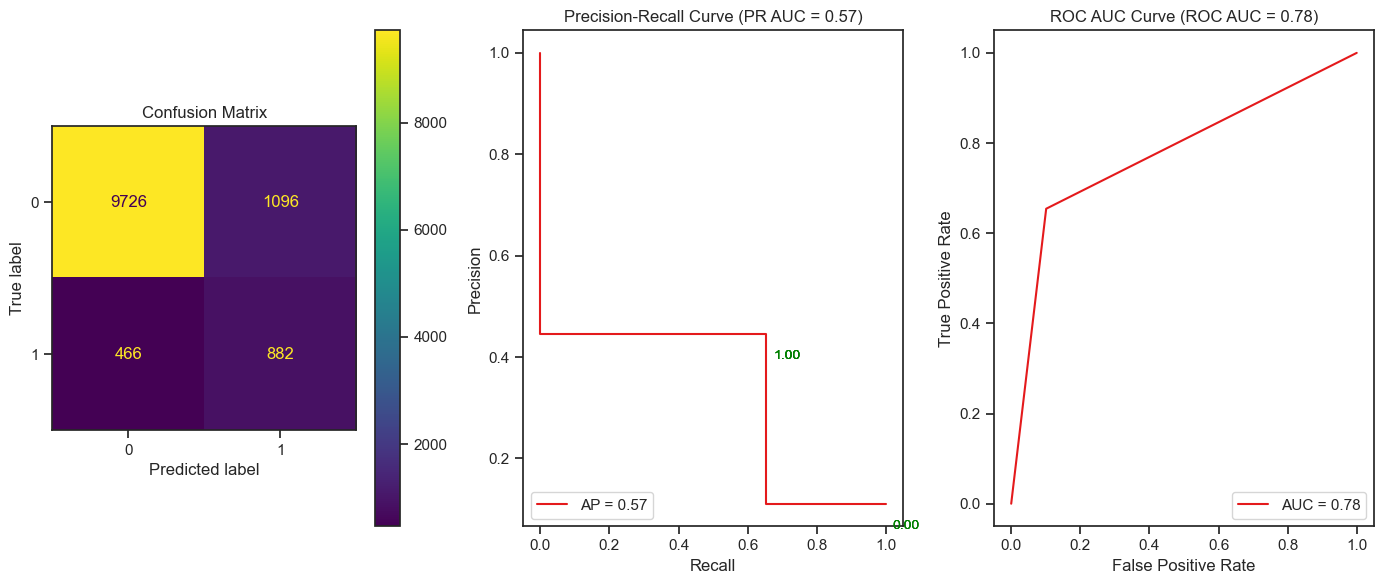


KNN with SMOTE on train (GridSearchCV)
                   Model                   Average Fit Time (seconds)  \
0  KNN with SMOTE on train (GridSearchCV)           0.017383            

   Train F1 score (cv)  Test F1 score (cv)  Test F1 score  \
0       0.933543             0.876849         0.530367      

   Train Accuracy score (cv)  Test Accuracy score (cv)  Test Accuracy score  \
0          0.953484                   0.911697               0.871652         

   PR AUC score  ROC AUC score  True Positives  False Positives  \
0    0.569249      0.776514           882            1096         

   True Negatives  False Negatives  
0       9726             466        


In [285]:
###########################################################################################################
# Iteration3: KNN model with SMOTE resampled data on train. HyperParameter tuning with GridSearchCV.
###########################################################################################################


# Create a pipeline for numeric features with polynomial transformation and scaling
numeric_transformer = Pipeline(steps=[
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler())
])

# Create a ColumnTransformer that applies transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),  # Apply polynomial and scaling to numeric features
        ('cat_bin', 'passthrough', categorical_feature_names)  # Pass through already encoded features
    ]
)

# KNN classifier
knn = KNeighborsClassifier(metric='minkowski')

# Create the pipeline with the preprocessor, and KNN
knn_pipe_w_smote = Pipeline([
    ('preprocessor', preprocessor),
    ('model', knn)
])

# Define parameter grid
param_grid = {
    'preprocessor__num__poly__degree': [1, 2, 3, 5, 6],           # Polynomial degrees to test
    'model__n_neighbors': [3, 5, 7, 10]                           # KNN neighbors to test
}

# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=knn_pipe_w_smote,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1',
    cv=skf,  
    verbose=1,
    n_jobs=-1,
    return_train_score=True
   # random_state=42
)

# Fit GridSearchCV to the training data
grid_search.fit(X1_train, y1_train)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best estimator
best_estimator = grid_search.best_estimator_

# Fit best estimator to the training data
best_estimator.fit(X1_train, y1_train)

# Get the index of the best parameter set based on F1
best_index = grid_search.best_index_

# Retrieve all keys in cv_results_ dictionary
all_param_names = grid_search.cv_results_.keys()

# print("All parameter names in cv_results_:")
# for param in all_param_names:
#   print(param)

# Get the mean fit time for the best parameter set
best_fit_time = grid_search.cv_results_['mean_fit_time'][best_index]

# Get train and test F1 score
train_f1 = grid_search.cv_results_['mean_train_f1'][best_index]
test_f1 = grid_search.cv_results_['mean_test_f1'][best_index]

# Get train and test accuracy score
train_accuracy = grid_search.cv_results_['mean_train_accuracy'][best_index]
test_accuracy = grid_search.cv_results_['mean_test_accuracy'][best_index]


# Print best parameters
print(f"Best Parameters: {best_params}")

# Get metrics by calling function - fp, fn, single PR AUC and ROC AUC values
metrics = evaluate_model(best_estimator, X1_test, y1_test, 0.6)

######################################################################################################
# Results Summary: Use best KNN Classifier from GridSearch and capture results in a data-frame
######################################################################################################
results_dict_knn3 = {
    'Model': 'KNN with SMOTE on train (GridSearchCV)',
    'Average Fit Time (seconds)': [best_fit_time],
    'Train F1 score (cv)': [train_f1],
    'Test F1 score (cv)': [test_f1],
    'Test F1 score'     : metrics['f1_score'],
    'Train Accuracy score (cv)': [train_accuracy],
    'Test Accuracy score (cv)' : [test_accuracy],
    'Test Accuracy score'  : metrics['accuracy_score'],
    'PR AUC score'         : metrics['pr_auc_value'],
    'ROC AUC score'        : metrics['roc_auc_value'],
    'True Positives'       : metrics['true_positives'],
    'False Positives'      : metrics['false_positives'],
    'True Negatives'       : metrics['true_negatives'],
    'False Negatives'      : metrics['false_negatives']
}

results_df_knn3 = pd.DataFrame(results_dict_knn3)

print("\nKNN with SMOTE on train (GridSearchCV)")
print(results_df_knn3)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92     10822
           1       0.45      0.71      0.55      1348

    accuracy                           0.87     12170
   macro avg       0.70      0.80      0.74     12170
weighted avg       0.90      0.87      0.88     12170



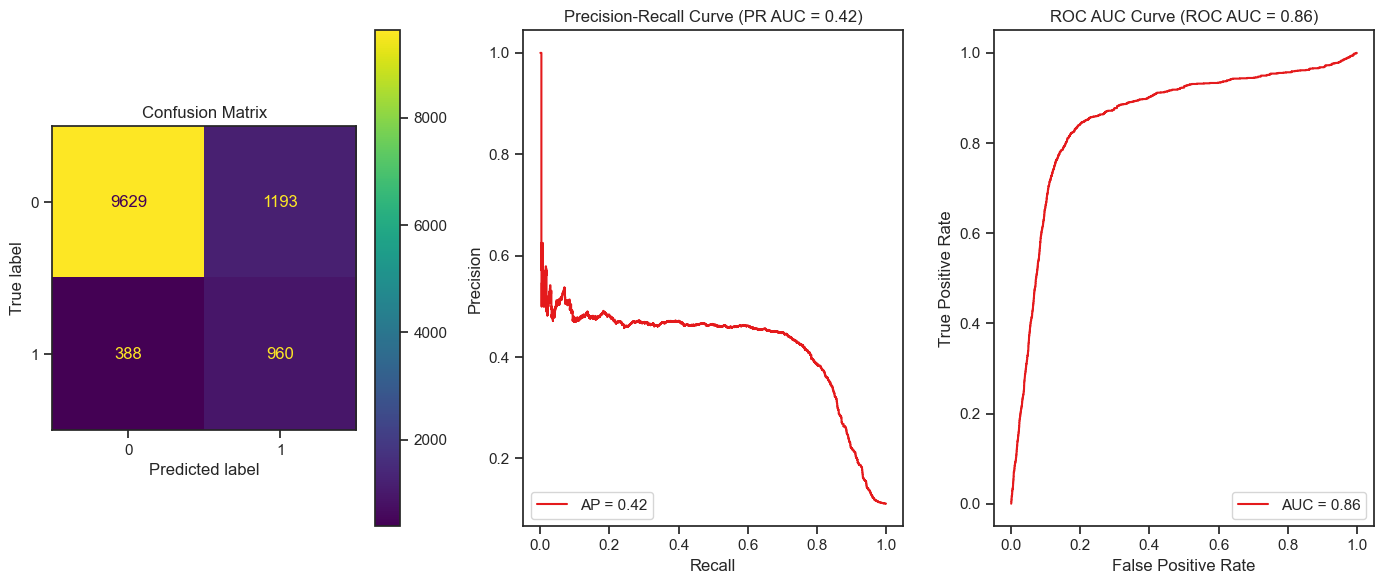


Comparison of KNN Results (Prior vs. Optimal Threshold)
                              Model                             Threshold  \
0                        KNN with SMOTE on train (GridSearchCV)       0.6   
1  KNN (GridSearchCV best estimator) threshold tuned for max F1  0.098625   

   Test F1 score (at threshold)  PR AUC score  ROC AUC score  True Positives  \
0            0.530367              0.569249      0.776514           882        
1            0.548415              0.421287      0.856292           960        

   False Positives  True Negatives  False Negatives  
0       1096             9726             466        
1       1193             9629             388        


In [338]:
######################################################################################################
# Tuning threshold for KNN classifier from Iteration3
######################################################################################################

# Call function to tune threshold based on f1 score
tune_results_knn = tune_threshold_for_f1(best_estimator, X1_test, y1_test)


# Create dictionary with two rows: one from Iteration3 results and another with optimal threshold results
tune_results_dict_knn = {
    'Model': [
        results_dict_knn3['Model'],
        'KNN (GridSearchCV best estimator) threshold tuned for max F1'
    ],
    'Threshold': [
        '0.6',
        tune_results_knn['optimal_threshold']
    ],
    'Test F1 score (at threshold)': [
        results_dict_knn3['Test F1 score'], 
        tune_results_knn['max_f1_score']
    ],
    'PR AUC score': [
        results_dict_knn3['PR AUC score'],
        tune_results_knn['pr_auc_value']
    ],
    'ROC AUC score': [
        results_dict_knn3['ROC AUC score'],
        tune_results_knn['roc_auc_value']
    ],
    'True Positives': [
        results_dict_knn3['True Positives'], 
        tune_results_knn['true_positives']
    ],
    'False Positives': [
        results_dict_knn3['False Positives'], 
        tune_results_knn['false_positives']
    ],
    'True Negatives': [
        results_dict_knn3['True Negatives'], 
        tune_results_knn['true_negatives']
    ],
    'False Negatives': [
        results_dict_knn3['False Negatives'], 
        tune_results_knn['false_negatives']
    ]
}

# Convert to DataFrame
tune_results_df_knn = pd.DataFrame(tune_results_dict_knn)

# Display
print("\nComparison of KNN Results (Prior vs. Optimal Threshold)")
print(tune_results_df_knn)


In [339]:
###############################################################################################
# Results Summary: All iterations of KNN Classifier model
###############################################################################################
pd.set_option('display.max_colwidth', None)
results_df = pd.concat([results_df_knn2, results_df_knn, results_df_knn3], ignore_index=True)

# Open file in write mode and add the title for first
with open('results/knn_all_iterations_summary.csv', 'w') as f:
    results_df.set_index('Model', inplace=True)
    f.write('Results Summary: All iterations of KNN model\n') 
    results_df.to_csv(f, header=True)  
    f.write('\n')

tune_results_df_knn_final = tune_results_df_knn.copy()
# Open file in append mode and add title for second 
with open('results/knn_all_iterations_summary.csv', 'a') as f:
    f.write('\nResults Summary: Compare KNN models with decision threshold fine tuned\n') 
    tune_results_df_knn.set_index('Model', inplace=True)
    tune_results_df_knn.to_csv(f, header=True)  
    f.close()


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10822
           1       0.95      0.95      0.95     10821

    accuracy                           0.95     21643
   macro avg       0.95      0.95      0.95     21643
weighted avg       0.95      0.95      0.95     21643

PR AUC Value: 0.96
ROC AUC Score: 0.95
False Positives: 548
False Negatives: 544


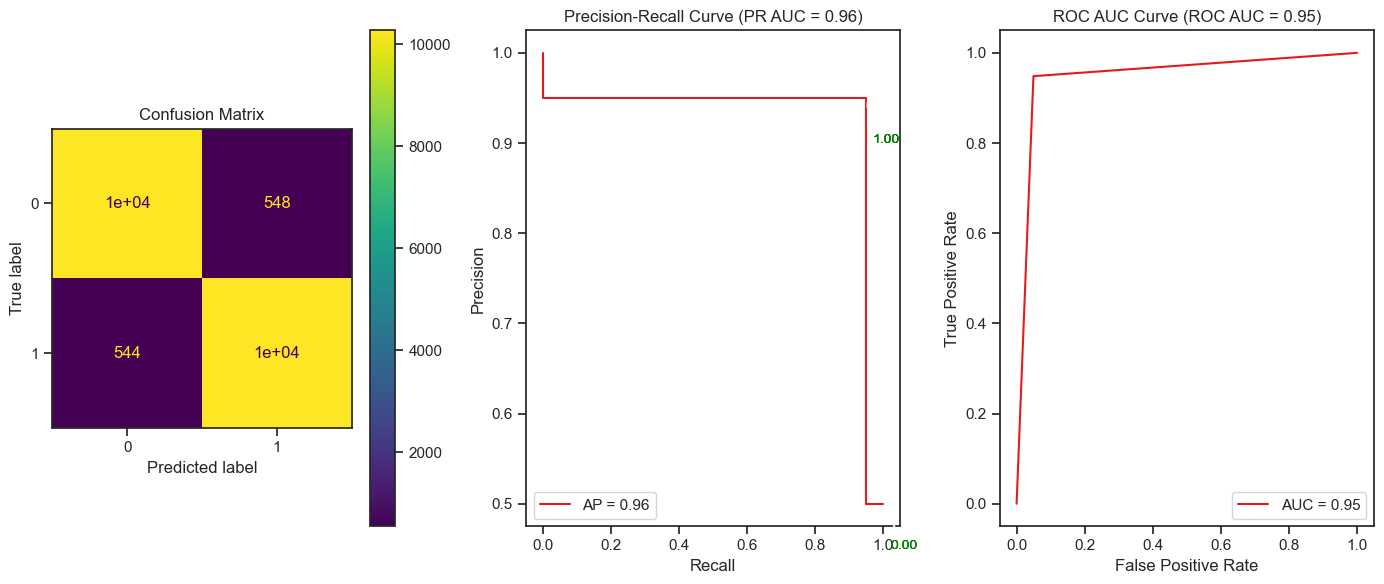


SVC with SMOTE on whole
           Model            Average Fit Time (seconds)  Train F1 score (cv)  \
0  SVC with SMOTE on whole           50.587329               0.956112         

   Test F1 score (cv)  Test F1 score  Train Accuracy score (cv)  \
0       0.945326         0.949552             0.956153            

   Test Accuracy score (cv)  Test Accuracy score  PR AUC score  ROC AUC score  \
0          0.945345               0.949545          0.962309      0.949452      

   True Positives  False Positives  True Negatives  False Negatives  
0       10277            548             10274            544        


In [288]:
###########################################################################################################
# Iteration1: SVM Classifier with all defaults. This uses SMOTE resampling on entire data-set.
###########################################################################################################

# Create a pipeline for numeric features with NO polynomial transformation and scaling
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create a ColumnTransformer that applies transformations
preprocessor_no_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),            # Apply scaling to numeric features
        ('cat_bin', 'passthrough', categorical_feature_names)  # Pass through already encoded features
    ]
)


# Pipeline with SVC classifier
svc_pipe = Pipeline([('transform', preprocessor_no_poly), 
                     ('model', SVC(probability=True, random_state=42))])
svc_pipe.fit(X_train, y_train)

# Scoring dictionary for multiple metrics
scoring = {
    'f1': 'f1',
    'accuracy': 'accuracy'
}

# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and compute multiple metrics
cv_results = cross_validate(svc_pipe, X_train, y_train, cv=skf, scoring=scoring, return_train_score=True)

# Extract and print the F1 scores
f1_scores_svc_train = cv_results['train_f1']
f1_scores_svc = cv_results['test_f1']


# Extract and print the accuracy scores
accuracy_scores_svc_train = cv_results['train_accuracy']
accuracy_scores_svc = cv_results['test_accuracy']

# Fit time as metric
fit_times = cv_results['fit_time']
avg_fit_time = np.mean(fit_times)


# Get metrics by calling function - fp, fn, single PR AUC and ROC AUC values
metrics = evaluate_model(svc_pipe, X_test, y_test, 0.5)
######################################################################################################
# Results Summary: Use SVC scores and capture results in a data-frame
######################################################################################################
results_dict_svc = {
    'Model': ['SVC with SMOTE on whole'],
    'Average Fit Time (seconds)': [avg_fit_time],
    'Train F1 score (cv)': [np.mean(f1_scores_svc_train)],
    'Test F1 score (cv)' : [np.mean(f1_scores_svc)],
    'Test F1 score'      : metrics['f1_score'],
    'Train Accuracy score (cv)': [np.mean(accuracy_scores_svc_train)],
    'Test Accuracy score (cv)' : [np.mean(accuracy_scores_svc)],
    'Test Accuracy score'      : metrics['accuracy_score'],
    'PR AUC score'        : metrics['pr_auc_value'],
    'ROC AUC score'       : metrics['roc_auc_value'],
    'True Positives'      : metrics['true_positives'],
    'False Positives'      : metrics['false_positives'],
    'True Negatives'       : metrics['true_negatives'],
    'False Negatives'      : metrics['false_negatives']
}

results_df_svc = pd.DataFrame(results_dict_svc)

print("\nSVC with SMOTE on whole")
print(results_df_svc)


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93     10822
           1       0.49      0.84      0.62      1348

    accuracy                           0.89     12170
   macro avg       0.73      0.86      0.78     12170
weighted avg       0.92      0.89      0.90     12170

PR AUC Value: 0.62
ROC AUC Score: 0.78
False Positives: 1177
False Negatives: 218


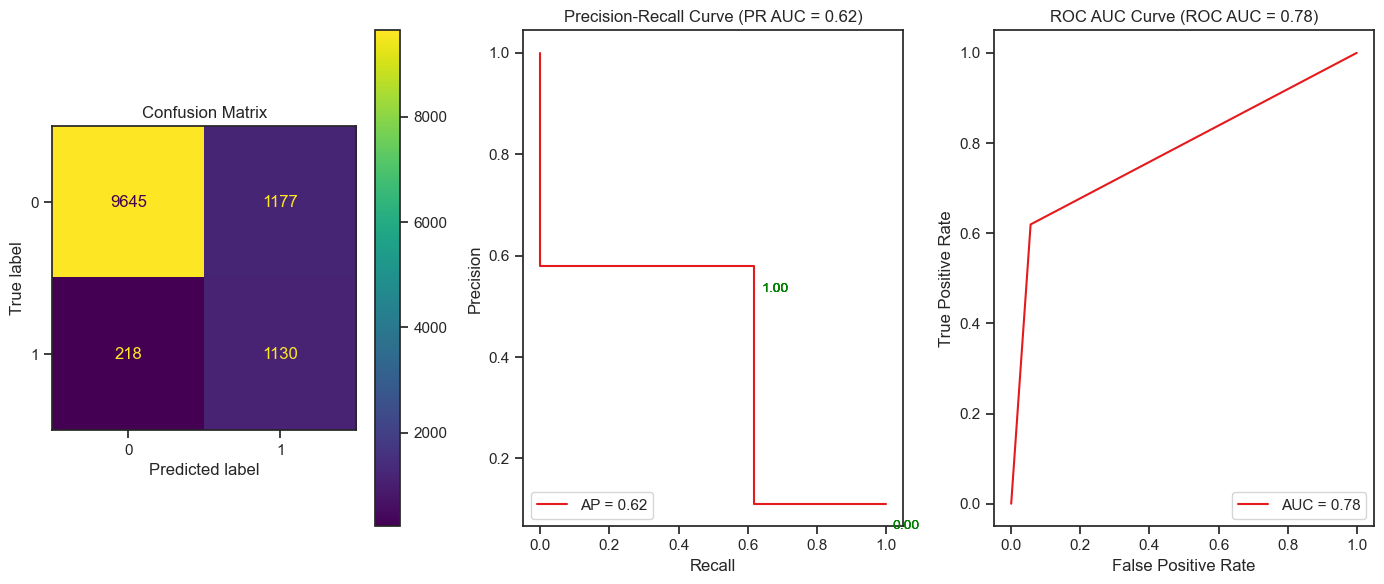


SVC with SMOTE on train
           Model            Average Fit Time (seconds)  Train F1 score (cv)  \
0  SVC with SMOTE on train           45.276531               0.889373         

   Test F1 score (cv)  Test F1 score  Train Accuracy score (cv)  \
0       0.876814         0.618331             0.919826            

   Test Accuracy score (cv)  Test Accuracy score  PR AUC score  ROC AUC score  \
0          0.910448               0.885374          0.620122      0.781627      

   True Positives  False Positives  True Negatives  False Negatives  
0       1130            1177             9645             218        


In [289]:
###########################################################################################################
# Iteration2: SVM Classifier. This uses SMOTE resampling with training data.
###########################################################################################################

# Scoring dictionary for multiple metrics
scoring = {
    'f1': 'f1',
    'accuracy': 'accuracy'
}

# Create a pipeline for numeric features with NO polynomial transformation and scaling
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create a ColumnTransformer that applies transformations
preprocessor_no_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),            # Apply scaling to numeric features
        ('cat_bin', 'passthrough', categorical_feature_names)  # Pass through already encoded features
    ]
)

# SVC Classifier with deaultclass_weight to penalize the majority class
svc_default = SVC(probability=True, random_state=42, class_weight='balanced')

# Create the pipeline with the preprocessor, and SVC
svc_pipe_w_smote = Pipeline([
    ('preprocessor', preprocessor_no_poly),
    ('model', svc_default)
])
svc_pipe_w_smote.fit(X1_train, y1_train)


# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and compute multiple metrics
cv_results = cross_validate(svc_pipe_w_smote, X1_train, y1_train, cv=skf, scoring=scoring, return_train_score=True)

# Extract and print the F1 scores
f1_scores_svc_train = cv_results['train_f1']
f1_scores_svc = cv_results['test_f1']

# Extract and print the accuracy scores
accuracy_scores_svc_train = cv_results['train_accuracy']
accuracy_scores_svc = cv_results['test_accuracy']

# Fit time as metric
fit_times = cv_results['fit_time']
avg_fit_time = np.mean(fit_times)


# Get metrics by calling function - fp, fn, single PR AUC and ROC AUC values
metrics = evaluate_model(svc_pipe_w_smote, X1_test, y1_test, 0.6)
######################################################################################################
# Results Summary: Use SVC scores and capture results in a data-frame
######################################################################################################
results_dict_svc2 = {
    'Model': 'SVC with SMOTE on train',
    'Average Fit Time (seconds)': [avg_fit_time],
    'Train F1 score (cv)': [np.mean(f1_scores_svc_train)],
    'Test F1 score (cv)' : [np.mean(f1_scores_svc)],
    'Test F1 score'      : metrics['f1_score'],
    'Train Accuracy score (cv)': [np.mean(accuracy_scores_svc_train)],
    'Test Accuracy score (cv)' : [np.mean(accuracy_scores_svc)],
    'Test Accuracy score'      : metrics['accuracy_score'],
    'PR AUC score'        : metrics['pr_auc_value'],
    'ROC AUC score'       : metrics['roc_auc_value'],
    'True Positives'      : metrics['true_positives'],
    'False Positives'      : metrics['false_positives'],
    'True Negatives'       : metrics['true_negatives'],
    'False Negatives'      : metrics['false_negatives']
}

pd.set_option('display.max_colwidth', None)
results_df_svc2 = pd.DataFrame(results_dict_svc2)

print("\nSVC with SMOTE on train")
print(results_df_svc2)


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92     10822
           1       0.45      0.71      0.55      1348

    accuracy                           0.87     12170
   macro avg       0.70      0.80      0.74     12170
weighted avg       0.90      0.87      0.88     12170



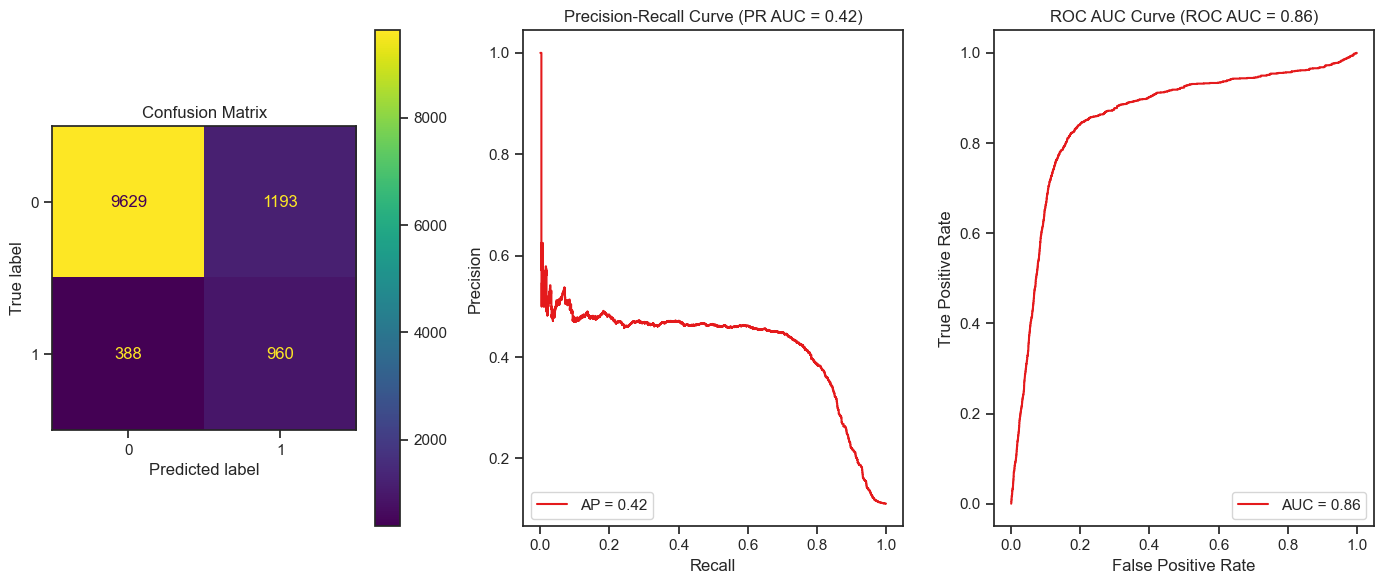


Comparison of SVC Results (Prior vs. Optimal Threshold)
                         Model                        Threshold  \
0                             SVC with SMOTE on train       0.6   
1  SVC with SMOTE on train threshold tuned for max F1  0.098625   

   Test F1 score (at threshold)  PR AUC score  ROC AUC score  True Positives  \
0            0.618331              0.620122      0.781627          1130        
1            0.548415              0.421287      0.856292           960        

   False Positives  True Negatives  False Negatives  
0       1177             9645             218        
1       1193             9629             388        


In [319]:
######################################################################################################
# Tuning threshold for SVC classifier from Iteration2
######################################################################################################

# Call function to tune decision threshold based on f1 score
tune_results_svc2 = tune_threshold_for_f1(best_estimator, X1_test, y1_test)


# Create dictionary with two rows: one from Iteration3 results and another with optimal threshold results
tune_results_dict_svc2 = {
    'Model': [
        results_dict_svc2['Model'],
        'SVC with SMOTE on train threshold tuned for max F1'
    ],
    'Threshold': [
        '0.6',
        tune_results_svc2['optimal_threshold']
    ],
    'Test F1 score (at threshold)': [
        results_dict_svc2['Test F1 score'], 
        tune_results_svc2['max_f1_score']
    ],
    'PR AUC score': [
        results_dict_svc2['PR AUC score'],
        tune_results_svc2['pr_auc_value']
    ],
    'ROC AUC score': [
        results_dict_svc2['ROC AUC score'],
        tune_results_svc2['roc_auc_value']
    ],
    'True Positives': [
        results_dict_svc2['True Positives'], 
        tune_results_svc2['true_positives']
    ],
    'False Positives': [
        results_dict_svc2['False Positives'], 
        tune_results_svc2['false_positives']
    ],
    'True Negatives': [
        results_dict_svc2['True Negatives'], 
        tune_results_svc2['true_negatives']
    ],
    'False Negatives': [
        results_dict_svc2['False Negatives'], 
        tune_results_svc2['false_negatives']
    ]
}

# Convert to DataFrame
tune_results_df_svc2 = pd.DataFrame(tune_results_dict_svc2)

# Display
print("\nComparison of SVC Results (Prior vs. Optimal Threshold)")
print(tune_results_df_svc2)


Optimal kernel is rbf with cross-validation F1 score of 0.752264477004817
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'model__kernel': 'rbf', 'model__gamma': 1, 'model__C': 10}

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     10822
           1       0.47      0.29      0.36      1348

    accuracy                           0.88     12170
   macro avg       0.69      0.62      0.65     12170
weighted avg       0.87      0.88      0.87     12170

PR AUC Value: 0.39
ROC AUC Score: 0.60
False Positives: 443
False Negatives: 957


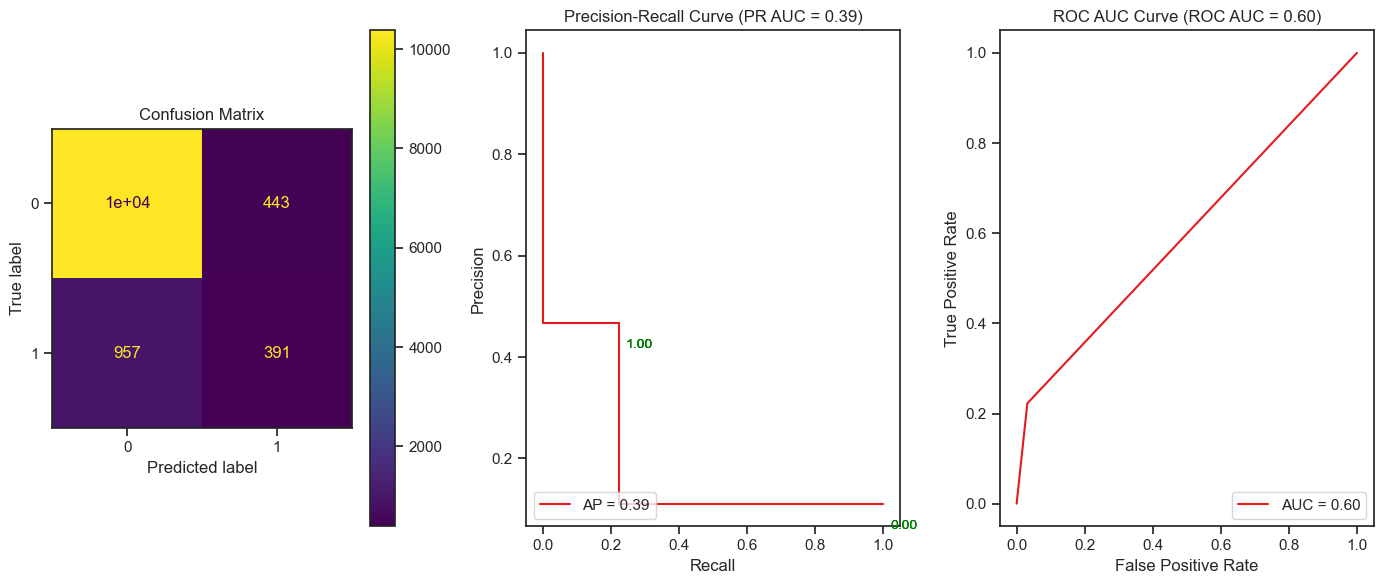


SVC with SMOTE on train (GridSearchCV)
                   Model                   Average Fit Time (seconds)  \
0  SVC with SMOTE on train (GridSearchCV)          609.691094           

   Train F1 score (cv)  Test F1 score (cv)  Test F1 score  \
0       0.991425             0.920493         0.358387      

   Train Accuracy score (cv)  Test Accuracy score (cv)  Test Accuracy score  \
0          0.994255                   0.946497               0.884963         

   PR AUC score  ROC AUC score  True Positives  False Positives  \
0    0.388342      0.595521           391             443         

   True Negatives  False Negatives  
0       10379            957        


In [291]:
###########################################################################################################
# Iteration3: SVM Classifier. This uses SMOTE resampling with training data. HyperParameter tuning. 
###########################################################################################################

# Create a pipeline for numeric features with NO polynomial transformation and scaling
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create a ColumnTransformer that applies transformations
preprocessor_no_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),            # Apply scaling to numeric features
        ('cat_bin', 'passthrough', categorical_feature_names)  # Pass through already encoded features
    ]
)

# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optimal Kernel selection
kernels = ['poly', 'rbf', 'sigmoid']
cv_scores = []
for k in kernels:
    svc = SVC(kernel=k, probability=True, random_state=42, class_weight='balanced')
    scores = cross_val_score(svc, X1_train, y1_train, cv=skf, scoring='f1')
    cv_scores.append(scores.mean())

optimal_kernel = kernels[cv_scores.index(max(cv_scores))]
print(f"Optimal kernel is {optimal_kernel} with cross-validation F1 score of {max(cv_scores)}")

# Params for GridSearch
params = {
    'model__C': [0.1, 1, 10, 100],
    'model__gamma': [1, 0.1, 0.01, 0.001],
    'model__kernel': [optimal_kernel],
}

# Create the pipeline with the preprocessor, and SVC
svc_pipe_w_smote = Pipeline([
    ('preprocessor', preprocessor_no_poly),
    ('model', SVC(probability=True, random_state=42, class_weight='balanced'))
])

# Set up RandomizedSearchCV
grid_search = RandomizedSearchCV(
    estimator=svc_pipe_w_smote,
    param_distributions=params,
    scoring=scoring,
    refit='f1',
    cv=skf,  
    verbose=1,
    n_jobs=-1,
    return_train_score=True,
    random_state=42
)

# Fit GridSearchCV to the training data
grid_search.fit(X1_train, y1_train)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best estimator
best_estimator = grid_search.best_estimator_
best_estimator.fit(X1_train, y1_train)

# Get the index of the best parameter set based on F1
best_index = grid_search.best_index_

# Retrieve all keys in cv_results_ dictionary
all_param_names = grid_search.cv_results_.keys()

# print("All parameter names in cv_results_:")
# for param in all_param_names:
#   print(param)

# Get the mean fit time for the best parameter set
best_fit_time = grid_search.cv_results_['mean_fit_time'][best_index]

# Get train and test F1 score
train_f1 = grid_search.cv_results_['mean_train_f1'][best_index]
test_f1 = grid_search.cv_results_['mean_test_f1'][best_index]

# Get train and test accuracy score
train_accuracy = grid_search.cv_results_['mean_train_accuracy'][best_index]
test_accuracy = grid_search.cv_results_['mean_test_accuracy'][best_index]


# Print best parameters and scores
print(f"Best Parameters: {best_params}")

# Get metrics by calling function - fp, fn, single PR AUC and ROC AUC values
metrics = evaluate_model(best_estimator, X1_test, y1_test, 0.6)
######################################################################################################
# Results Summary: Use best KNN Classifier from GridSearch and capture results in a data-frame
######################################################################################################
results_dict_svc3 = {
    'Model': 'SVC with SMOTE on train (RandomizedSearchCV)',
    'Average Fit Time (seconds)': [best_fit_time],
    'Train F1 score (cv)': [train_f1],
    'Test F1 score (cv)' : [test_f1],
    'Test F1 score'      : metrics['f1_score'],
    'Train Accuracy score (cv)': [train_accuracy],
    'Test Accuracy score (cv)' : [test_accuracy],
    'Test Accuracy score'      : metrics['accuracy_score'],
    'PR AUC score'         : metrics['pr_auc_value'],
    'ROC AUC score'        : metrics['roc_auc_value'],
    'True Positives'       : metrics['true_positives'],
    'False Positives'      : metrics['false_positives'],
    'True Negatives'       : metrics['true_negatives'],
    'False Negatives'      : metrics['false_negatives']
}

results_df_svc3 = pd.DataFrame(results_dict_svc3)

print("\nSVC with SMOTE on train (GridSearchCV)")
print(results_df_svc3)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92     10822
           1       0.45      0.71      0.55      1348

    accuracy                           0.87     12170
   macro avg       0.70      0.80      0.74     12170
weighted avg       0.90      0.87      0.88     12170



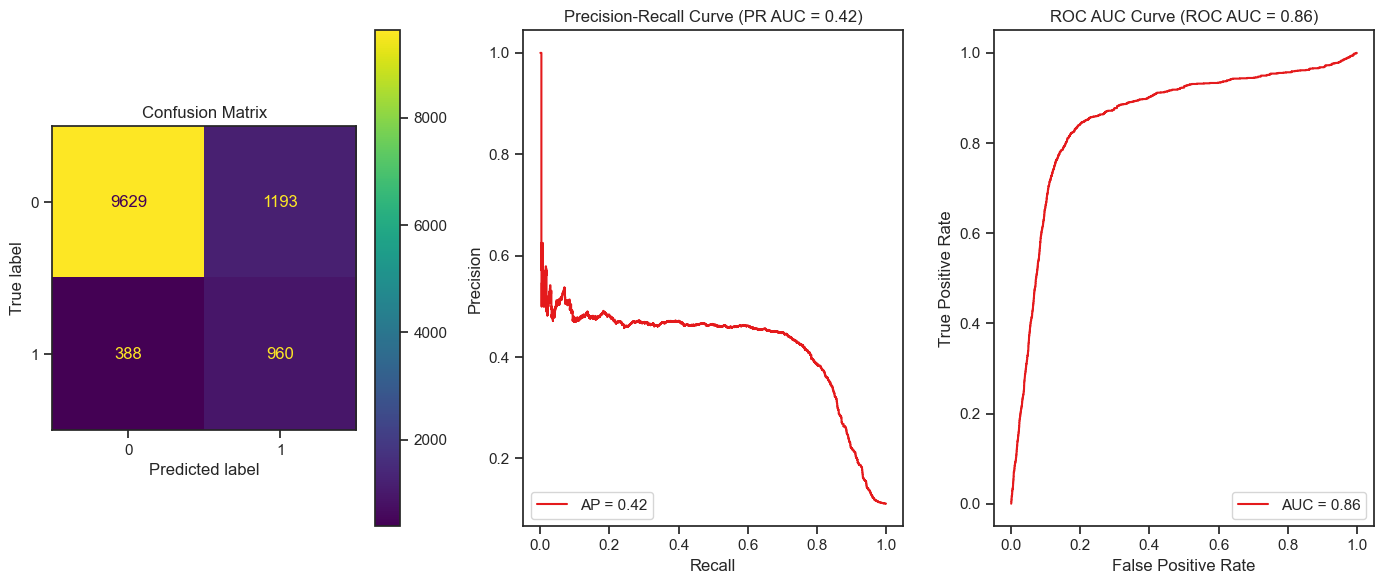


Comparison of SVC Best Estimator Results (Prior vs. Optimal Threshold)
                                 Model                                 \
0                              SVC with SMOTE on train (GridSearchCV)   
1  SVC (RandomizedSearchCV best estimator) threshold tuned for max F1   

  Threshold  Test F1 score (at threshold)  PR AUC score  ROC AUC score  \
0       0.6            0.358387              0.388342      0.595521      
1  0.098625            0.548415              0.421287      0.856292      

   True Positives  False Positives  True Negatives  False Negatives  
0        391             443             10379            957        
1        960            1193              9629            388        


In [341]:
######################################################################################################
# Tuning threshold for SVC classifier from Iteration3
######################################################################################################

# Call function to tune threshold based on f1 score
tune_results_svc3 = tune_threshold_for_f1(best_estimator, X1_test, y1_test)


# Create dictionary with two rows: one from Iteration3 results and another with optimal threshold results
tune_results_dict_svc3 = {
    'Model': [
        results_dict_svc3['Model'],
        'SVC (RandomizedSearchCV best estimator) threshold tuned for max F1'
    ],
    'Threshold': [
        '0.6',
        tune_results_svc3['optimal_threshold']
    ],
    'Test F1 score (at threshold)': [
        results_dict_svc3['Test F1 score'], 
        tune_results_svc3['max_f1_score']
    ],
    'PR AUC score': [
        results_dict_svc3['PR AUC score'],
        tune_results_svc3['pr_auc_value']
    ],
    'ROC AUC score': [
        results_dict_svc3['ROC AUC score'],
        tune_results_svc3['roc_auc_value']
    ],
    'True Positives': [
        results_dict_svc3['True Positives'], 
        tune_results_svc3['true_positives']
    ],
    'False Positives': [
        results_dict_svc3['False Positives'], 
        tune_results_svc3['false_positives']
    ],
    'True Negatives': [
        results_dict_svc3['True Negatives'], 
        tune_results_svc3['true_negatives']
    ],
    'False Negatives': [
        results_dict_svc3['False Negatives'], 
        tune_results_svc3['false_negatives']
    ]
}

# Convert to DataFrame
tune_results_df_svc3 = pd.DataFrame(tune_results_dict_svc3)

# Display
print("\nComparison of SVC Best Estimator Results (Prior vs. Optimal Threshold)")
print(tune_results_df_svc3)


In [342]:
###############################################################################################
# Results Summary: All iterations of SVC Classifier model
###############################################################################################
pd.set_option('display.max_colwidth', None)
results_df = pd.concat([results_df_svc2, results_df_svc, results_df_svc3], ignore_index=True)

# Open file in write mode and add the title for first
with open('results/svc_all_iterations_summary.csv', 'w') as f:
    results_df.set_index('Model', inplace=True)
    f.write('Results Summary: All iterations of SVC model\n') 
    results_df.to_csv(f, header=True)  
    f.write('\n')


tune_results_df_svc = pd.concat([tune_results_df_svc2, tune_results_df_svc3], ignore_index=True)
print(tune_results_df_svc.columns)
tune_results_df_svc_final = tune_results_df_svc.copy()

# Open file in append mode and add title for second 
with open('results/svc_all_iterations_summary.csv', 'a') as f:
    f.write('\nResults Summary: Compare SVC models with decision threshold fine tuned\n') 
    tune_results_df_svc.set_index('Model', inplace=True)
    tune_results_df_svc.to_csv(f, header=True)  
    f.close()

Index(['Model', 'Threshold', 'Test F1 score (at threshold)', 'PR AUC score',
       'ROC AUC score', 'True Positives', 'False Positives', 'True Negatives',
       'False Negatives'],
      dtype='object')


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [ ]:
###################################################################################################################
# 1. Decided not to feature engineer any more since the target KPIs are being met across all models. 
# Decision Tree thus far appears to be best in terms of balancing the # of false positives and false negatives.
# SVM can be improved in terms of balancing # of FPs and FNs
# Logistic Regression (Iteration3) and KNN's as alternates also perform reasonably well as-is wrt target KPIs
# 2. Hence, hyper-parameter tuning the Decision Tree Classifier and SVM Classifier to observe further improvements
# with FNs and FPs.
# 



Index(['Model', 'Average Fit Time (seconds)', 'Train F1 score (cv)',
       'Test F1 score (cv)', 'Test F1 score', 'Train Accuracy score (cv)',
       'Test Accuracy score (cv)', 'Test Accuracy score', 'PR AUC score',
       'ROC AUC score', 'True Positives', 'False Positives', 'True Negatives',
       'False Negatives'],
      dtype='object')


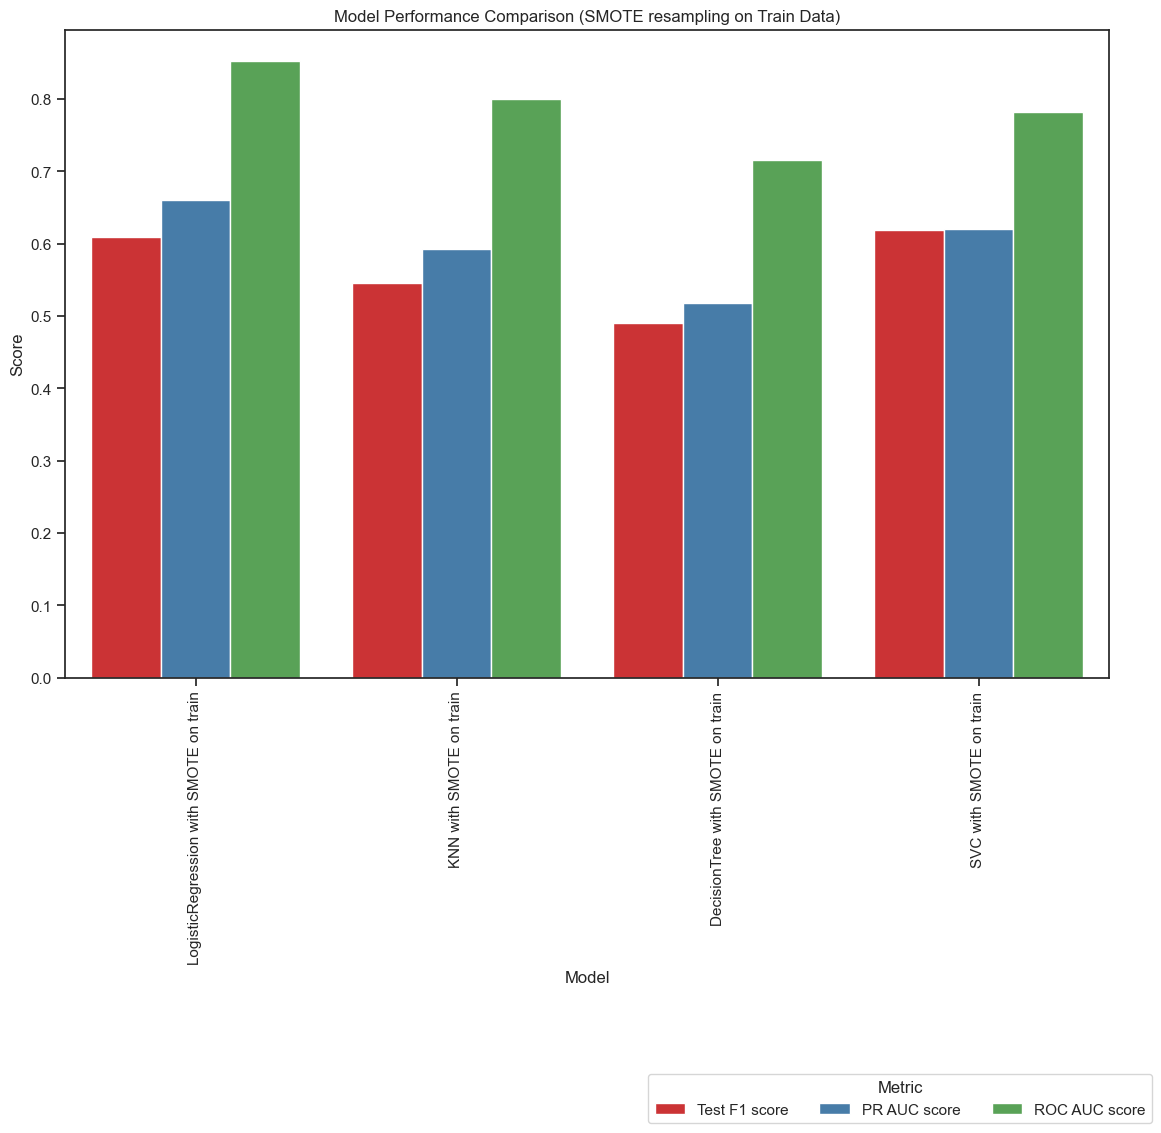

In [347]:
###################################################################################################################
# Results Summary across ALL models that uses SMOTE resampled training data
###################################################################################################################
pd.set_option('display.max_colwidth', None)
results_df_smote_on_train = pd.concat([results_df_lgr1, results_df_knn2, results_df_dc2, results_df_svc2], ignore_index=True)

# Write summary to csv
print(results_df_smote_on_train.columns)
results_df_smote_on_train.set_index('Model', inplace=True)
results_df_smote_on_train.to_csv('results/results_summary_with_smote_on_train.csv')


# Plot multiple comparison metrics across these models
results_df_smote_on_train = results_df_smote_on_train.reset_index()
results_melted = results_df_smote_on_train.melt(id_vars='Model', 
                                                value_vars=['Test F1 score', 'PR AUC score', 'ROC AUC score'],
                                                var_name='Metric', value_name='Score')

# Create a bar plot with metrics Test F1 score, PR AUC score, ROC AUC score
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Score', hue='Metric', data=results_melted)

# Add title and labels
plt.title('Model Performance Comparison (SMOTE resampling on Train Data)')
plt.xlabel('Model')
plt.ylabel('Score')

# Display the plot
plt.xticks(rotation=90)
plt.legend(title='Metric', bbox_to_anchor=(0.8, -0.6), loc='upper center', ncol=3)
plt.show()

###################################################################################################################
# Conclusion: In this comparison, the Support Vector Classifier (SVC) model demonstrates superior performance 
# with a higher F1 score compared to the Logistic Regression model. 
# However, the Logistic Regression model shows competitive performance with similar F1 scores, and it 
# outperforms the SVC model in both Precision-Recall AUC (PR AUC) and ROC AUC scores. 
# Additionally, the Logistic Regression model offers advantages in terms of interpretability and efficiency, 
# consuming less time for both training and prediction.
###################################################################################################################

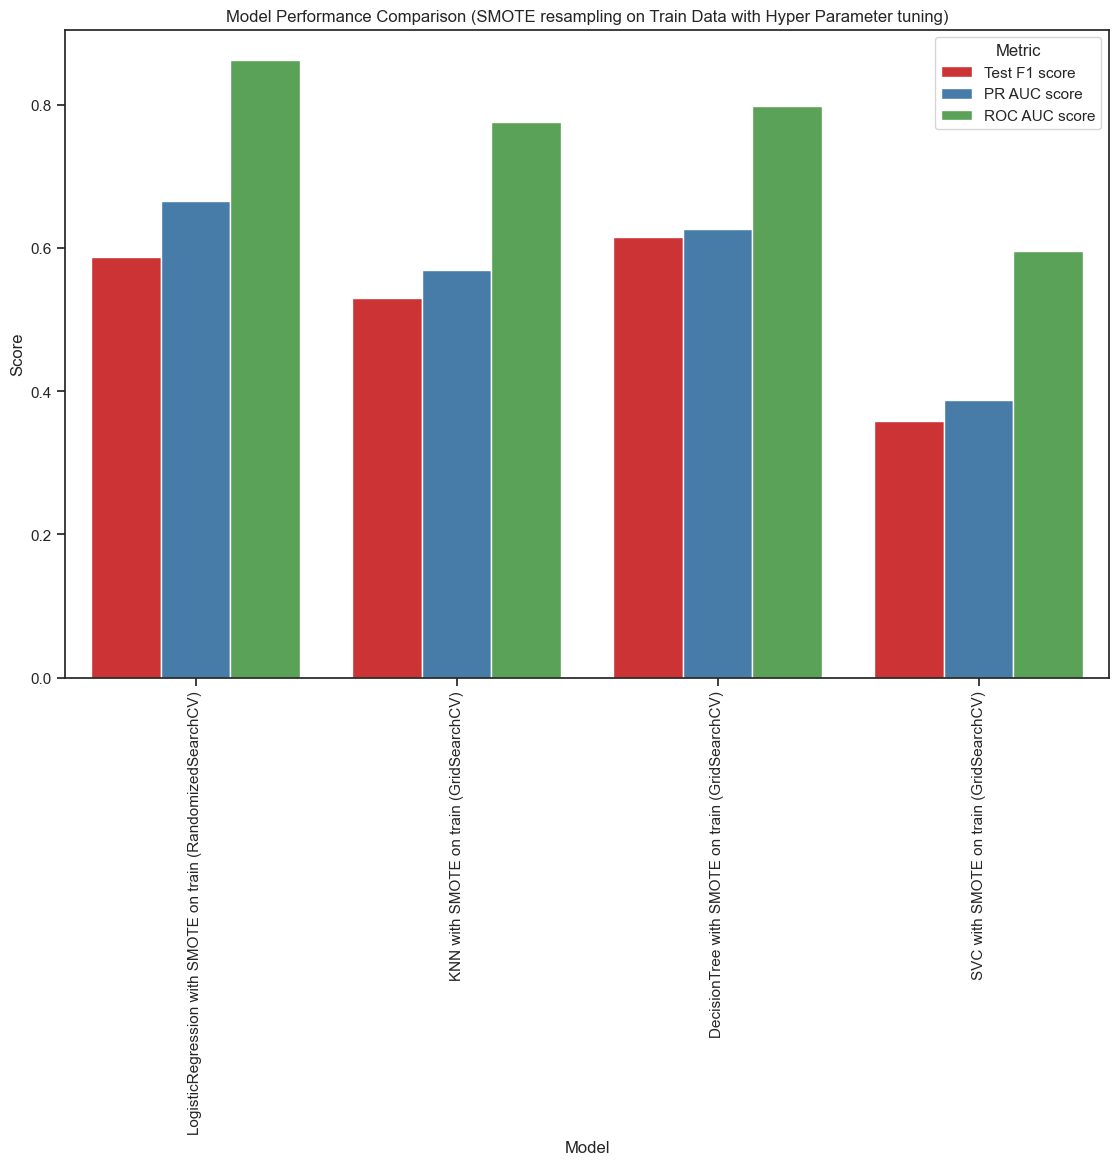

In [354]:
###################################################################################################################
# Results Summary for HyperParameter tuned Models. These include:
# 1. models trained on SMOTE-resampled data with hyperparameter tuning using grid/randomized search
###################################################################################################################
pd.set_option('display.max_colwidth', None)
results_df_smote_train_hyperparam_tune = pd.concat([results_df_lgr3, results_df_knn3, results_df_dc3, results_df_svc3], ignore_index=True)

# Write summary to csv
results_df_smote_train_hyperparam_tune.set_index('Model', inplace=True)
results_df_smote_train_hyperparam_tune.to_csv('results/results_summary_with_hyperparam_tune.csv')

# Plot multiple comparison metrics across these models
results_df_smote_train_hyperparam_tune = results_df_smote_train_hyperparam_tune.reset_index()
results_melted = results_df_smote_train_hyperparam_tune.melt(id_vars='Model', 
                                                value_vars=['Test F1 score', 'PR AUC score', 'ROC AUC score'],
                                                var_name='Metric', value_name='Score')

# Create a bar plot with metrics Test F1 score, PR AUC score, ROC AUC score
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Score', hue='Metric', data=results_melted)

# Add title and labels
plt.title('Model Performance Comparison (SMOTE resampling on Train Data with Hyper Parameter tuning)')
plt.xlabel('Model')
plt.ylabel('Score')

# Display the plot
plt.xticks(rotation=90)
plt.legend(title='Metric')
plt.show()

###################################################################################################################
# Conclusion: With hyperparameter tuning using GridSearchCV/RandomizedSearchCV, the Decision Tree model achieves 
# the highest F1 score, followed by the Logistic Regression model. However, Logistic Regression 
# outperforms the Decision Tree in both Precision-Recall AUC (PR AUC) and ROC AUC scores. 
# Both models offer good interpretability, with the Decision Tree being more computationally efficient. 
# On the other hand, the Support Vector Classifier (SVC), with hyperparameter tuning, records the lowest F1, PR AUC, and ROC AUC scores.
###################################################################################################################

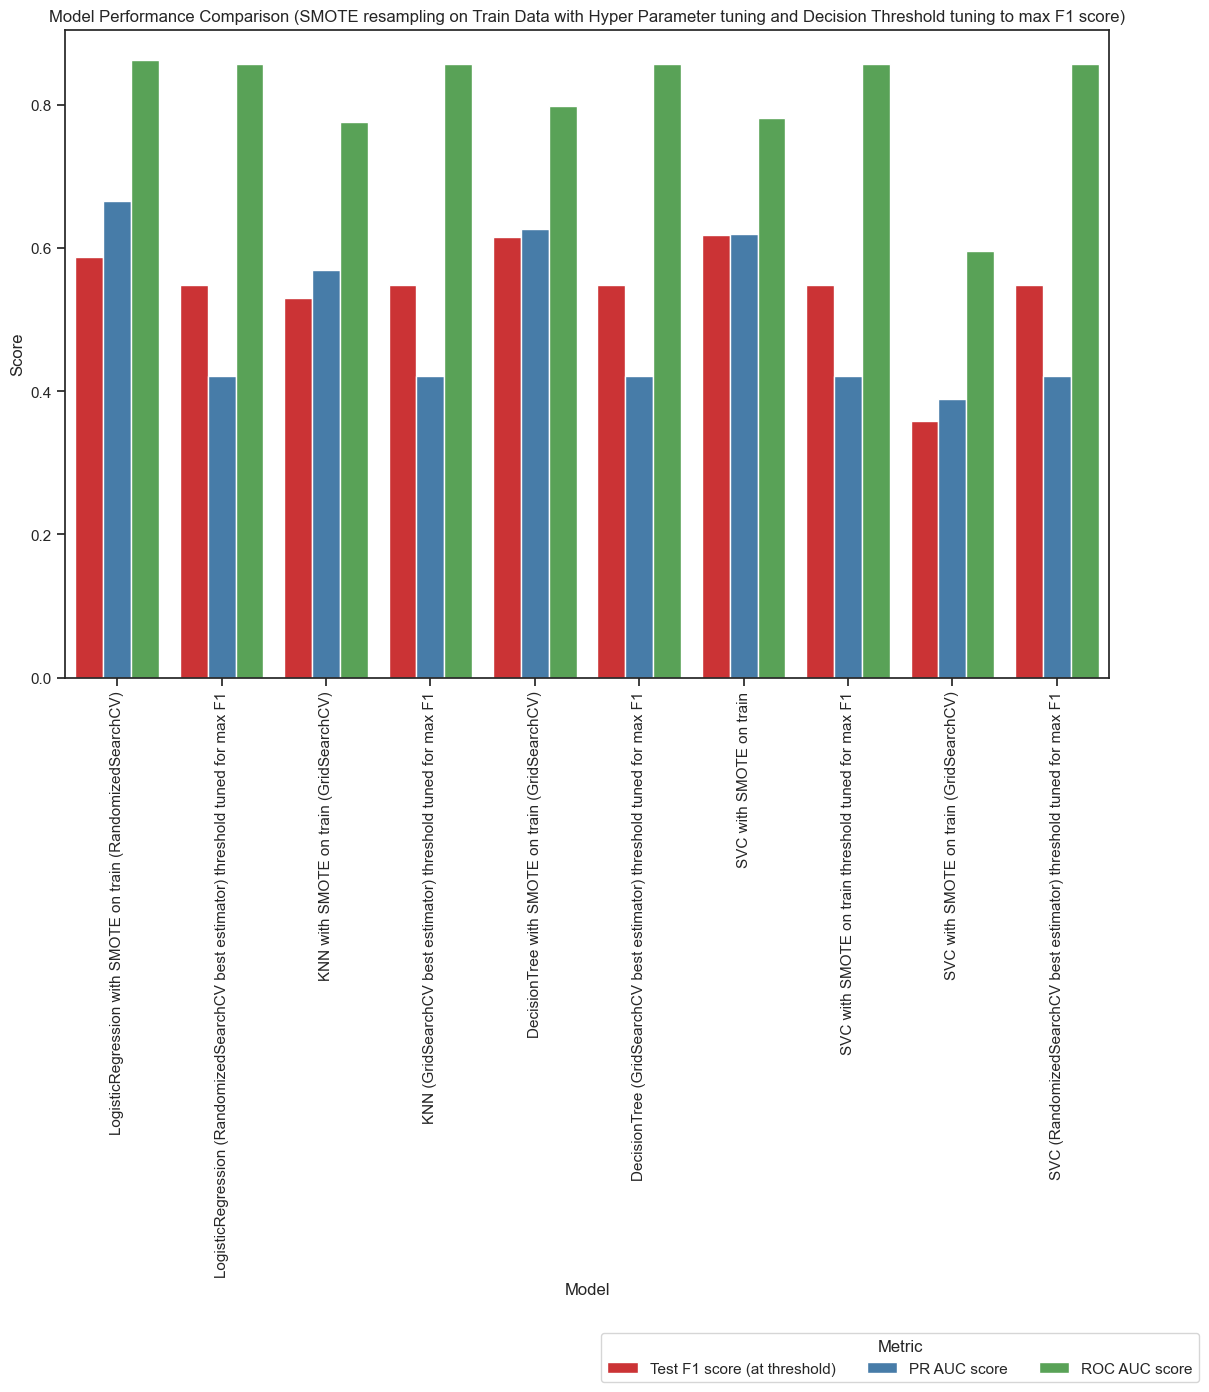

In [355]:
###################################################################################################################
# Results Summary with additional fine tuning to observe improvements over hyper parameter tuned models. 
# For additional tuning, decision threshold was fine-tuned to maximize the F1 score on the best estimators 
# from hyper parameter tuned models
###################################################################################################################
pd.set_option('display.max_colwidth', None)
results_df_smote_train_fine_tuned = pd.concat([tune_results_df_lgr_final, tune_results_df_knn_final, 
                                               tune_results_df_dc_final, tune_results_df_svc_final], ignore_index=True)

# Write summary to csv
results_df_smote_train_fine_tuned.set_index('Model', inplace=True)
results_df_smote_train_fine_tuned.to_csv('results/results_summary_with_more_fine_tune.csv')

# Plot multiple comparison metrics across these models
results_df_smote_train_fine_tuned = results_df_smote_train_fine_tuned.reset_index()
results_melted = results_df_smote_train_fine_tuned.melt(id_vars='Model', 
                                                value_vars=['Test F1 score (at threshold)', 'PR AUC score', 'ROC AUC score'],
                                                var_name='Metric', value_name='Score')

# Create a bar plot with metrics Test F1 score, PR AUC score, ROC AUC score
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Score', hue='Metric', data=results_melted)

# Add title and labels
plt.title('Model Performance Comparison (SMOTE resampling on Train Data with Hyper Parameter tuning and Decision Threshold tuning to max F1 score)')
plt.xlabel('Model')
plt.ylabel('Score')

# Display the plot
plt.xticks(rotation=90)
plt.legend(title='Metric', bbox_to_anchor=(0.8, -1.), loc='upper center', ncol=3)
plt.show()


#####################################################################################################################################
# Conclusion: After additional tuning of decision thresholds to maximize the F1 score, the best estimators from GridSearchCV/RandomizedSearchCV 
# were used for the Logistic Regression, Decision Tree, and SVC models. The SVC model was fine-tuned for its decision threshold 
# with both the basic (non-hyper-tuned) model and the best estimator from hyperparameter tuning, as the basic SVC model initially 
# showed the best performance, achieving a high F1 score along with well-balanced PR AUC and ROC AUC scores before hyper=parameter tuning.

# When optimizing for a higher F1 score, the hyperparameter-tuned Decision Tree model (without adjusting the decision threshold) 
# achieves the highest F1 score. This is followed by the basic (non-hyper-tuned) SVC model, and then the 
# hyperparameter-tuned Logistic Regression model. 
# However, fine-tuning the decision threshold to maximize the F1 score actually lowered the F1 score across all models, suggesting 
# that this step can be discarded.

# In terms of computational efficiency, the basic SVC model takes significantly longer to fit compared to the 
# hyperparameter-tuned Decision Tree and Logistic Regression models. 
# While the hyperparameter-tuned Logistic Regression model performs better in terms of PR AUC and ROC AUC 
# compared to the Decision Tree, both models are comparable in interpretability. 
# Additionally, the Decision Tree model is the fastest to train and predict.

# Recommendation: Deploy the hyperparameter-tuned Decision Tree model, as it offers a higher F1 score and faster fit/predict times 
# compared to the Logistic Regression model. This recommendation comes with the trade-off of forgoing the higher PR AUC and ROC AUC scores 
# provided by the hyperparameter-tuned Logistic Regression model.
#####################################################################################################################################

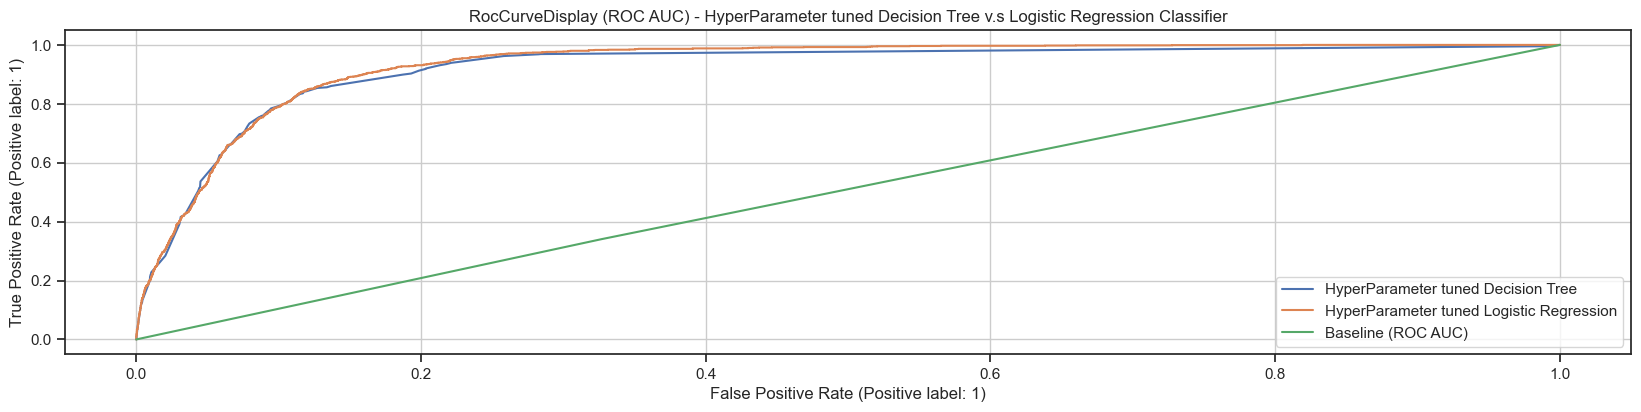

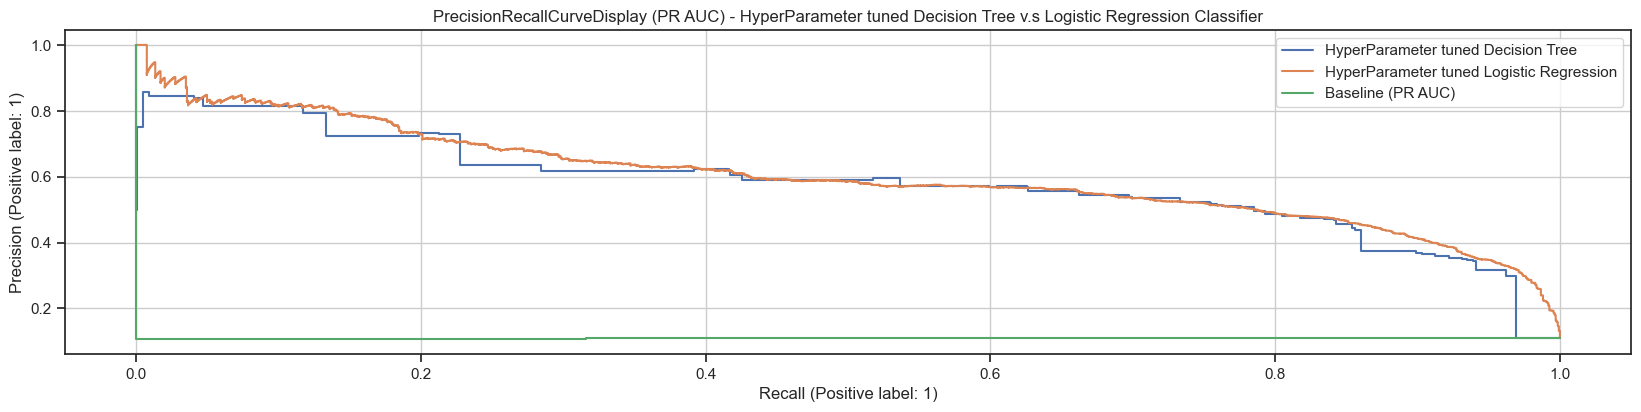

In [37]:
###################################################################################################################
# From Recommendation: Area under the curve for Precision Recall and ROC for hyper parameter tuned Decision Tree 
# classifier from Iteration3, with its hyper parameter tuned Logistic Regression Classifier from its Iteration3
###################################################################################################################

fig, ax = plt.subplots(figsize=(18, 4))
RocCurveDisplay.from_estimator(dc_grid.best_estimator_, X1_test, y1_test,  ax = ax, label = 'HyperParameter tuned Decision Tree')
RocCurveDisplay.from_estimator(lgr_grid_search.best_estimator_, X1_test, y1_test, ax = ax, label = 'HyperParameter tuned Logistic Regression')
RocCurveDisplay.from_estimator(dummy_clf1, X1_test, y1_test, ax = ax, label = 'Baseline (ROC AUC)')
plt.grid()
plt.title('RocCurveDisplay (ROC AUC) - HyperParameter tuned Decision Tree v.s Logistic Regression Classifier')
plt.legend();

fig1, ax1 = plt.subplots(figsize=(18, 4))
PrecisionRecallDisplay.from_estimator(dc_grid.best_estimator_, X1_test, y1_test, ax = ax1, label = 'HyperParameter tuned Decision Tree')
PrecisionRecallDisplay.from_estimator(lgr_grid_search.best_estimator_, X1_test, y1_test, ax = ax1, label = 'HyperParameter tuned Logistic Regression')
PrecisionRecallDisplay.from_estimator(dummy_clf1, X1_test, y1_test, ax = ax1, label = 'Baseline (PR AUC)')
plt.grid()
plt.title('PrecisionRecallCurveDisplay (PR AUC) - HyperParameter tuned Decision Tree v.s Logistic Regression Classifier')
plt.legend();


##### Questions